In [1]:
import xml.etree.ElementTree
import pandas as pd
import os, sys
import pickle

#MNET_PATH = '/Users/anamaria/git/molnet/code/'
#sys.path.append(MNET_PATH)

In [2]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

In [3]:
%load_ext autoreload
%autoreload 2

## Create metabolites dictionary

Parse metabolites list downloaded from HMDB in xml format;

And extract into a dictionary the information we are interested in for each metabolite.

In [ ]:
path_to_hmdbfile = osp+ 'Metabolomics_datasets/serum_metabolites.xml'
et = xml.etree.ElementTree.parse(path_to_hmdbfile)
root = et.getroot()


In [ ]:
metabolites = {}
stringtag = '{http://www.hmdb.ca}'
for metabolite in root.findall(stringtag+'metabolite'):
    accid = metabolite.find(stringtag+'accession').text
    name = metabolite.find(stringtag+'name').text
    mass = metabolite.find(stringtag+'average_molecular_weight').text
    chemform = metabolite.find(stringtag+'chemical_formula').text
    smiles = metabolite.find(stringtag+'smiles').text
    kegg_id = metabolite.find(stringtag+'kegg_id').text
    metlin_id = metabolite.find(stringtag+'metlin_id').text
    
    biological_properties = metabolite.findall(stringtag+'biological_properties')
    for properties in biological_properties:
        pathways = properties.find(stringtag+'pathways')
        for pathway in pathways:
            kegg_map = pathway.find(stringtag+'kegg_map_id').text
    
    
    metabolites[accid] = (mass, chemform, name, smiles, metlin_id, kegg_id, kegg_map)  
    
with open(os.path.join(osp,'Metabolomics_datasets/metabolites.dict'), 'wb') as handle:
    pickle.dump(metabolites, handle)  

In [4]:
with open(os.path.join(osp,'Metabolomics_datasets/metabolites.dict'), 'rb') as file:
    metabolites = pickle.load(file)

In [5]:
metabolites

{'HMDB0000001': ('169.1811',
  'C7H11N3O2',
  '1-Methylhistidine',
  'CN1C=NC(C[C@H](N)C(O)=O)=C1',
  '3741',
  'C01152',
  None),
 'HMDB0000002': ('74.1249',
  'C3H10N2',
  '1,3-Diaminopropane',
  'NCCCN',
  '5081',
  'C00986',
  None),
 'HMDB0000005': ('102.0886',
  'C4H6O3',
  '2-Ketobutyric acid',
  'CCC(=O)C(O)=O',
  None,
  'C00109',
  None),
 'HMDB0000008': ('104.1045',
  'C4H8O3',
  '2-Hydroxybutyric acid',
  'CCC(O)C(O)=O',
  '3783',
  'C05984',
  'map00640'),
 'HMDB0000010': ('300.3921',
  'C19H24O3',
  '2-Methoxyestrone',
  '[H][C@@]12CCC(=O)[C@@]1(C)CC[C@]1([H])C3=C(CC[C@@]21[H])C=C(O)C(OC)=C3',
  '2578',
  'C05299',
  None),
 'HMDB0000011': ('104.1045',
  'C4H8O3',
  '(R)-3-Hydroxybutyric acid',
  'C[C@@H](O)CC(O)=O',
  None,
  'C01089',
  None),
 'HMDB0000012': ('228.202',
  'C9H12N2O5',
  'Deoxyuridine',
  'OC[C@H]1O[C@H](C[C@@H]1O)N1C=CC(=O)NC1=O',
  '5086',
  'C00526',
  None),
 'HMDB0000014': ('227.2172',
  'C9H13N3O4',
  'Deoxycytidine',
  'NC1=NC(=O)N(C=C1)[C@H]1C[C

## Load annotated data

In [6]:
with open(osp+'pymz/mzmine/peak_picked_files/filtered_peaksets.dict', 'rb') as file:
    peaks = pickle.load(file)

## Filter out data with no spectra

In [7]:
sys.path.append("/Users/anamaria/git/pymzm_mine")
#from mass_spec_utils.data_processing.alignment import JoinAligner
from alignment import JoinAligner
with open(os.path.join(osp,'pymz/mzmine/aligner_gp.txt'), 'rb') as file:
    aligner_gp = pickle.load(file)   

## Create the peakInfo object

In [8]:
#TODO: peakinfolist class
sys.path.append("..")
import peakinfo
peakInfoList = []
ms2_files = osp+ 'Metabolomics_datasets/hmdb_experimental_msms_spectra/'
for cid in peaks:
    peakInfo = peakinfo.PeakInfo(cid, peaks[cid][0], peaks[cid][1],aligner_gp, metabolites, ms2_files)
    peakInfo.add_pval(peaks[cid][2])
    peakInfo.add_tval(peaks[cid][3])
    peakInfo.add_mm_info(peaks[cid][4],peaks[cid][5], peaks[cid][6])
    peakInfo.add_std_match(peaks[cid][7], metabolites)
    
    peakInfoList.append(peakInfo)

In [10]:
with open(osp+'pymz/mzmine/peak_picked_files/filtered_peaks.peakinfo', 'wb') as handle:
    pickle.dump(peakInfoList, handle)

In [11]:
print((peakInfoList[1].best_ms2_match_adduct).score)

0.07125377552911867


In [17]:
for peak in peakInfoList:
    if peak.best_ms2_match_adduct:
        print(peak.best_ms2_match_adduct.hmdb)


C00064


C00245




























C00380















None


C00491
















C00250










C00328

C00073









None

































C00178






































































C00078

























C00065




























C00123



C00250
































C00041







C00147
















C00719






















C00123




















C00082


None




C00791








C00037

























C00791






















C00719









C00250










C00791













C00263


C00318

C00122


C00079












C00719





C00791



C00719






C00318





C00122

C00314



























C00719










































C00262












C00719




C00123





C00719


C00791


### Determining optimal cut-off score (cosine similarity)

In [12]:
scores = []
for peak in peakInfoList:
    if peak.best_ms2_match_adduct:
        scores.append(peak.best_ms2_match_adduct.score)

Text(0.5, 1.0, 'Distribution of scores')

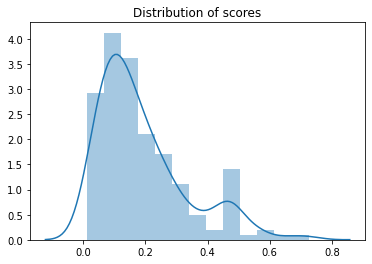

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(scores)
plt.title('Distribution of scores')

In [18]:
#TODO: also need to take into account the isomers, so need to calculate the formula
good_scores = []
bad_scores = []
minim = 1
for peak in peakInfoList:
    standards_kegg = peak.std_kegg_id
    if peak.best_ms2_match_adduct:
        ms2match = peak.best_ms2_match_adduct
        ms2match_kegg = metabolites[peak.best_ms2_match_adduct.hmdb][5]
    
    #get the scores for metabolites matching the standards annotation
        if standards_kegg == ms2match_kegg:
                    if ms2match.score < minim:
                        minim = ms2match.score
                    good_scores.append(ms2match.score)

                #get the scores for metabolites not matching with the standards annotation
        if standards_kegg != None:

                    if ms2match_kegg != standards_kegg:
                        #print(standards,i, name, score)
                        
                            bad_scores.append(ms2match.score)

        
print('Lowest score value for which the HMDB annotation matches with the ToxID annotation:',minim)

Lowest score value for which the HMDB annotation matches with the ToxID annotation: 0.2994606386011165


Text(0.5, 1.0, 'Distribution of good scores')

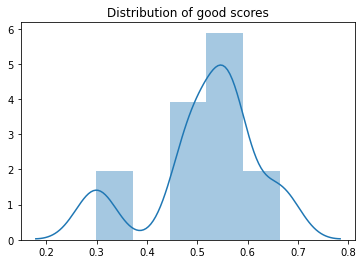

In [19]:
sns.distplot(good_scores)
plt.title('Distribution of good scores')

Text(0.5, 1.0, 'Distribution of bad scores')

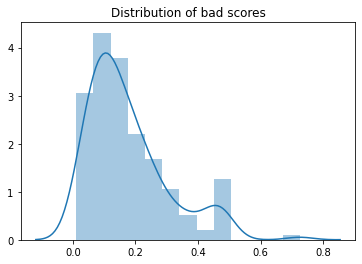

In [20]:
sns.distplot(bad_scores)
plt.title('Distribution of bad scores')

In [45]:
def plot_mirror(normalised_peaks_top, normalised_peaks_bottom):
    
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0})

    for mz,intensity in normalised_peaks_top:
        axs[0].plot([mz,mz], [0,intensity], 'k', color = 'r')
        axs[0].set_ylabel("Aligner Spectrum")
    
    for mz,intensity in normalised_peaks_bottom:
        axs[1].plot([mz,mz],[0,-intensity],'k', color = 'b')
        axs[1].set_ylabel("HMDB Spectrum")
   
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    plt.show()    
    


o-acetyl-l-serine  148.07345756155544
['(r)-mevalonate'] C00418
----
l-glutamine C00064 147.07640748274954
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine'] C00906
M-CO2+H[1+] : Nitroxoline 190.1555 C9H6N2O3 None 0.07125377552911867


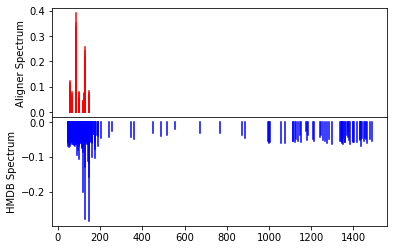

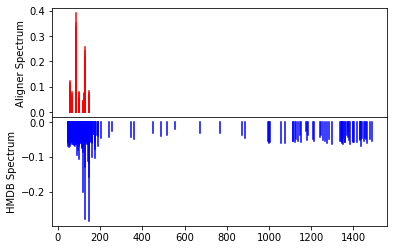

----
NaN  905.5937710121028
NaN NaN
----
NaN  810.6000113236278
NaN NaN
----
taurine C00245 126.0219806871916
['taurine'] C00245
M+Na[1+] : Dimethylglycine 103.1198 C4H9NO2 C01026 0.10210443207247256


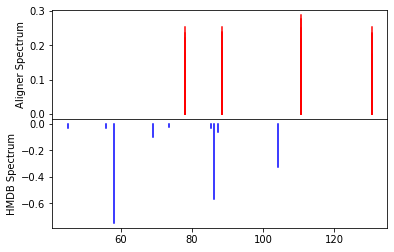

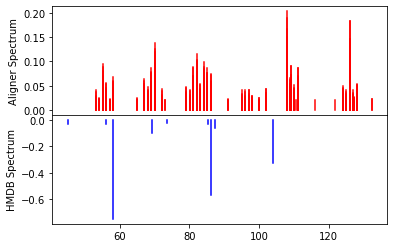

----
NaN  782.5687384354442
NaN NaN
----
NaN  812.6144790649414
NaN NaN
----
NaN  784.5840506302683
NaN NaN
----
NaN  835.6033615604524
NaN NaN
----
NaN  171.0764231430857
NaN NaN
----
NaN  169.05836848208781
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid'] C00064;C05100;C00819
----
NaN  785.5879516601562
NaN NaN
----
NaN  101.07095439850336
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine'] C00906
----
NaN  191.040284656343
NaN NaN
----
NaN  148.04266542004
NaN NaN
M+Na[1+] : Taurine 125.147 C2H7NO3S C00245 0.13708797942306056


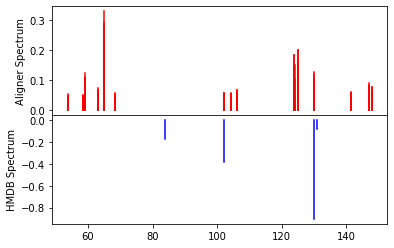

----
NaN  131.05327114306002
['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate'] C01879;C04281;C04282
----
NaN  837.618204752604
NaN NaN
----
NaN  130.04992655703896
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate', 'd-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', '5-oxo-l-proline'] C02238
M+H[1+] : Pyroglutamic acid 129.114 C5H7NO3 C01879 0.010514727372978212


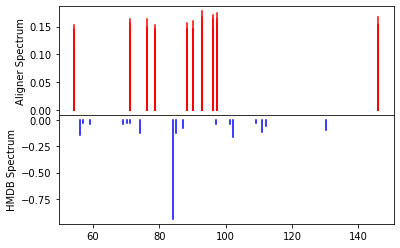

----
n(pi)-methyl-l-histidine  170.06167554098462
NaN NaN
----
sn-glycero-3-phosphocholine  258.1100018149928
NaN NaN
M-HCOOH+H[1+] : Ethacrynic acid 303.138 C13H12Cl2O4 None 0.09469661079330198


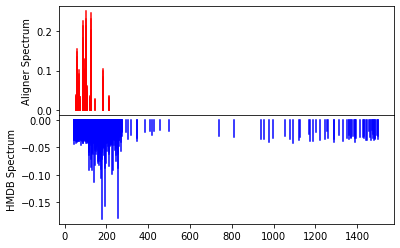

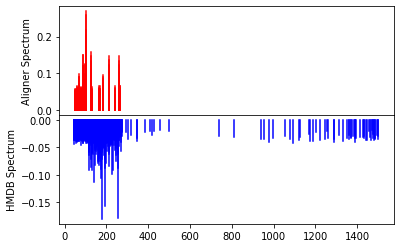

----
NaN  133.06077505412858
['n-carbamoyl-beta-alanine$l-asparagine'] C02642;C00152
----
NaN  149.08066248893738
['(r)-mevalonate'] C00418
----
NaN  166.05330748307077
NaN NaN
----
NaN  495.3275594559927
NaN NaN
----
NaN  834.6000561714172
NaN NaN
----
NaN  836.6139644499748
NaN NaN
----
NaN  520.3400409096166
NaN NaN
----
NaN  176.03766284072609
NaN NaN
----
NaN  380.2558107376098
['sphingosine 1-phosphate'] C06124
----
NaN  380.25582956167364
['sphingosine 1-phosphate'] C06124
----
NaN  787.6035939266808
NaN NaN
----
NaN  786.6000470613177
NaN NaN
----
NaN  176.07406287357722
NaN NaN
----
cytosine C00380 112.05056200027464
['cytosine (in dna)$cytosine'] C05522;C00380
----
NaN  796.6194324493408
NaN NaN
----
NaN  807.5720968535452
NaN NaN
----
NaN  792.5890053196957
NaN NaN
----
NaN  171.07645948309647
NaN NaN
M+K[1+] : Ureidopropionic acid 132.1179 C4H8N2O3 C02642 0.07229741550318824


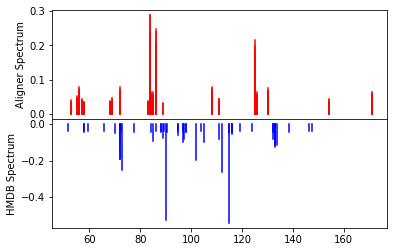

----
NaN  809.5875447591147
NaN NaN
----
NaN  743.5770635431462
NaN NaN
----
NaN  206.1273452258501
NaN NaN
----
NaN  766.5738016764321
NaN NaN
----
NaN  469.3119622055365
NaN NaN
----
NaN  512.334872713956
NaN NaN
M+NaCl[1+] : Cefixime 453.45 C16H15N5O7S2 C06881 0.12275130022783999


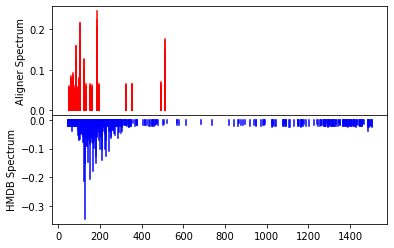

----
NaN  523.3591457166169
NaN NaN
----
NaN  522.3558831465872
NaN NaN
M+HCOONa[1+] : Cefixime 453.45 C16H15N5O7S2 C06881 0.1294808763485444


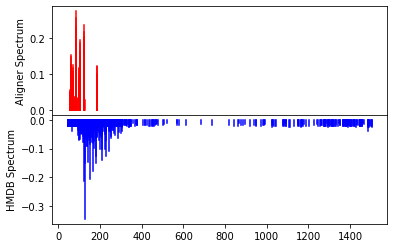

----
5-oxoproline  130.04995717500387
['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate$5-oxo-l-proline', 'd-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde'] C00217;C00025;C05938
M-H2O+H[1+] : L-Glutamic acid 147.1293 C5H9NO4 C00025 0.3102075634939863


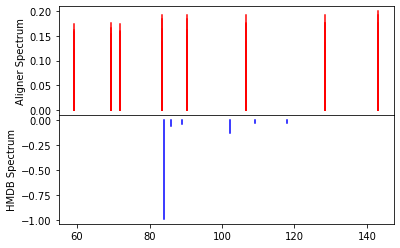

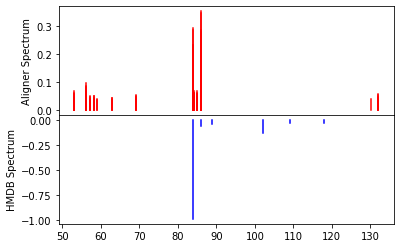

----
NaN  770.6031951904297
NaN NaN
----
NaN  759.5722881116368
NaN NaN
----
methylcysteine None 136.0427669178356
['l-homocysteine'] C00155
M+H[1+] : Adenine 135.1267 C5H5N5 C00147 0.2750234125407901


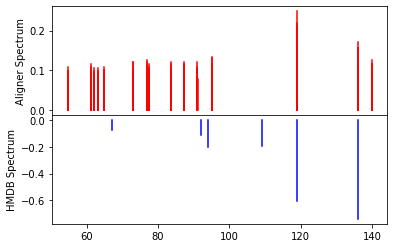

----
NaN  767.5771116059402
NaN NaN
----
NaN  194.1468843732561
NaN NaN
----
l-cystine C00491 241.03100315217048
['l-cystine; l-dicysteine; l-alpha-diamino-beta-dithiolactic acid'] C00491
M+HCOONa[1+] : Glycerol 3-phosphate 172.0737 C3H9O6P C00093 0.015895960532467925


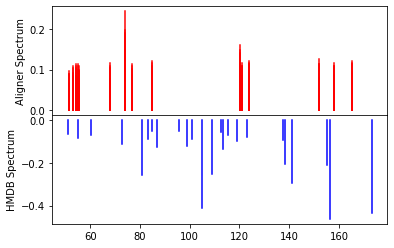

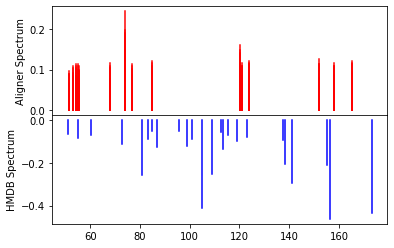

----
NaN  191.08493292331696
NaN NaN
----
NaN  758.5688291850843
NaN NaN
----
NaN  213.0222165089733
NaN NaN
----
NaN  794.6050793092642
NaN NaN
----
NaN  468.3084357766543
['timnodonyl carnitine'] tmndnccrn
M+NaCl[1+] : Ezetimibe 409.4252 C24H21F2NO3 None 0.03401744186104419


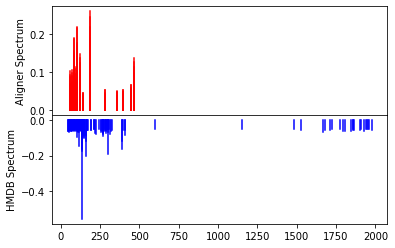

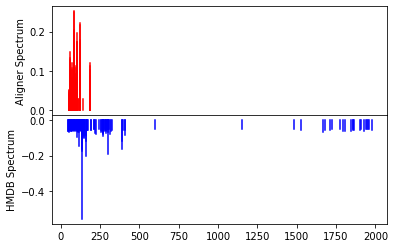

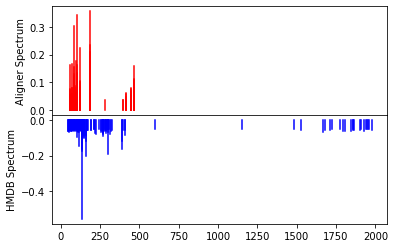

----
NaN  814.6262374014224
NaN NaN
----
NaN  757.5567353347252
NaN NaN
----
NaN  496.33967911569687
['docosa-4,7,10,13,16-pentaenoyl carnitine$clupanodonyl carnitine'] dcsptn1crn;clpndcrn
M-H4O2+H[1+] : Ketoconazole 531.431 C26H28Cl2N4O4 None 0.03576427355137224


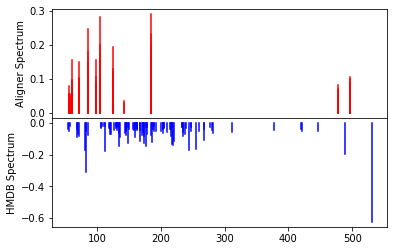

----
NaN  568.3397577459162
NaN NaN
----
NaN  498.34583282470703
NaN NaN
----
NaN  497.3431362352873
NaN NaN
----
NaN  482.3242121244732
NaN NaN
----
NaN  510.3556785583496
NaN NaN
M+NaCl[1+] : Doxazosin 451.4751 C23H25N5O5 C06970 0.014146366441248637


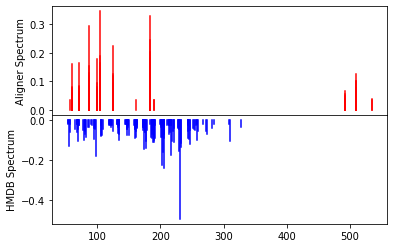

----
NaN  832.5839935878537
NaN NaN
----
5-aminolevulinate  132.05415382385254
NaN NaN
----
NaN  161.0923203901811
NaN NaN
----
pyridoxal C00250 168.1019774350253
['3-methoxytyramine$epinine; deoxyepinephrine'] C05587;C07453
----
NaN  400.34202806877363
['l-palmitoylcarnitine'] C02990
----
NaN  904.5903413192084
NaN NaN
----
NaN  213.12338502945443
NaN NaN
----
NaN  756.5531342450313
NaN NaN
----
NaN  172.0968251479299
NaN NaN
----
NaN  797.6236220537606
NaN NaN
----
NaN  158.15401699668482
NaN NaN
M+HCOOK[1+] : Methylguanidine 73.0971 C2H7N3 C02294 0.27092947172356924


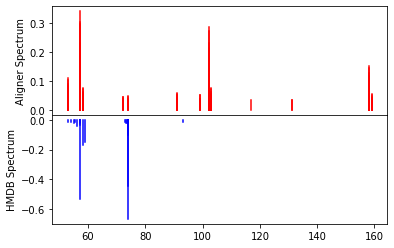

----
NaN  769.5926121303012
NaN NaN
----
o-acetyl-l-serine  148.07970658393756
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid'] C00064;C05100;C00819
----
NaN  799.6681079864502
NaN NaN
----
l-kynurenine C00328 209.09213899311263
['porphobilinogen', 'l-kynurenine$formyl-5-hydroxykynurenamine'] C00328;C05647
M+H2O+H[1+] : Nitroxoline 190.1555 C9H6N2O3 None 0.16610080193915222


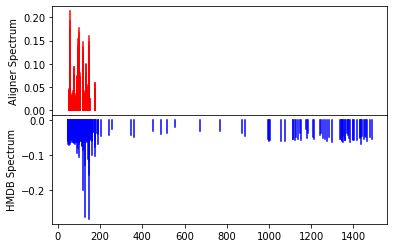

----
NaN  102.05497522065134
['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', 'l-allo-threonine$l-threonine'] C05519;C00188
----
l-methionine C00073 150.05838434319747
['l-methionine'] C00073
M(S34)+H[1+] : L-Glutamic acid 147.1293 C5H9NO4 C00025 0.147169986287923


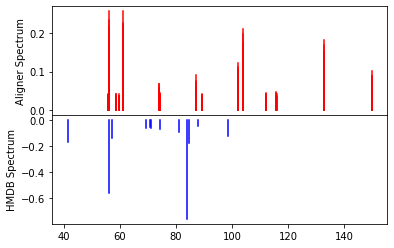

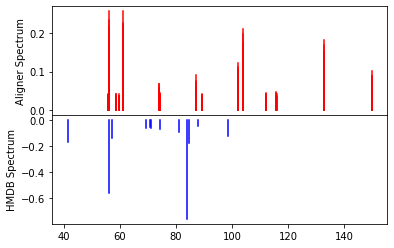

----
NaN  806.5687849017938
NaN NaN
----
NaN  545.3430971891984
NaN NaN
----
NaN  689.5586529632112
NaN NaN
----
NaN  147.07638807857737
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid'] C00064;C05100;C00819
M+H+Na[2+] : Apigenin 270.2369 C15H10O5 C01477 0.05132016957070613


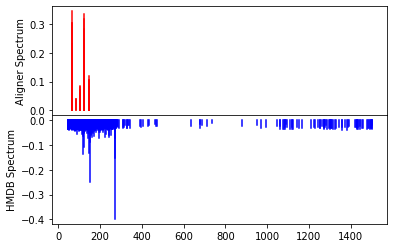

----
NaN  788.6120846396997
NaN NaN
----
NaN  542.3226473533501
NaN NaN
M+HCOONa[1+] : Clofazimine 473.396 C27H22Cl2N4 C06915 0.010441743908240658


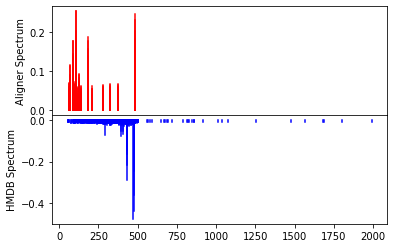

----
NaN  181.0720427293044
['1,7-dimethylxanthine; paraxanthine$'] C13747;C07480
M+NaCl[1+] : Niacinamide 122.1246 C6H6N2O C00153 0.1020251595017188


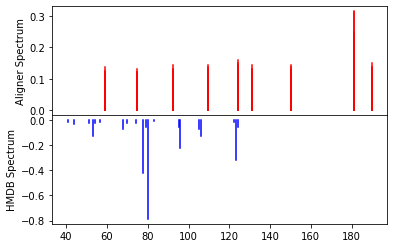

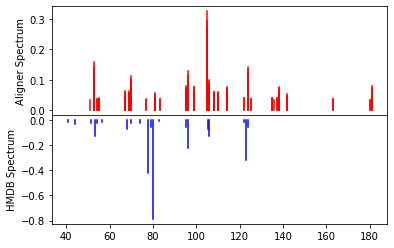

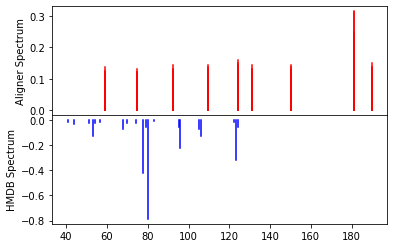

----
NaN  120.0808048248291
['l-phenylalanine$', 'tyramine$n,n-dimethylaniline n-oxide$phenylethanolamine; 2-amino-1-phenylethanol'] C00483;C01183;C02735
M-H2O+H[1+] : Tyramine 137.179 C8H11NO C00483 0.33746686279200255


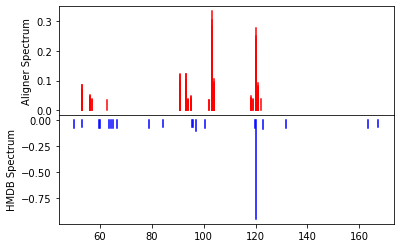

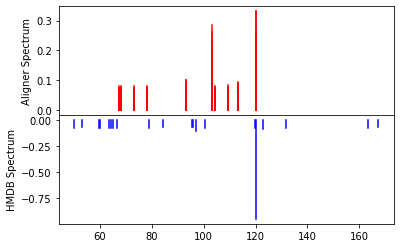

----
NaN  287.2215092307643
NaN NaN
M+H[1+] : Luteolin 286.2363 C15H10O6 C01514 0.14870913649504763


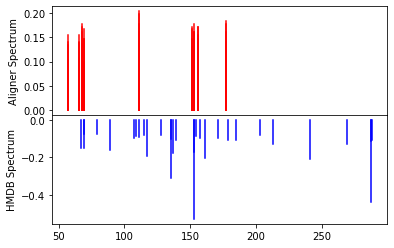

----
2-phenylglycine None 152.05416253033806
['l-methionine'] C00073
----
NaN  217.10714016538682
NaN NaN
----
NaN  104.05283815720502
['l-methionine'] C00073
----
NaN  742.5739977155413
NaN NaN
----
NaN  288.21679216272685
['l-octanoylcarnitine'] C02838
M(C13)+H[1+] : Luteolin 286.2363 C15H10O6 C01514 0.08390340868126529


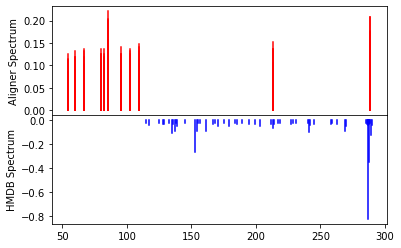

----
NaN  772.5841475777004
NaN NaN
----
NaN  207.1128806064004
NaN NaN
----
NaN  615.5388493691721
NaN NaN
----
NaN  279.15896526135896
NaN NaN
M+K[1+] : Anserine 240.259 C10H16N4O3 C01262 0.24594820380791443


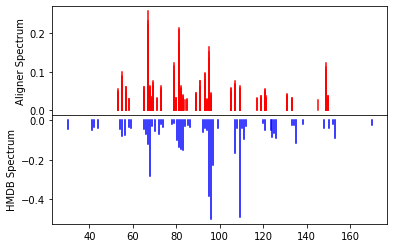

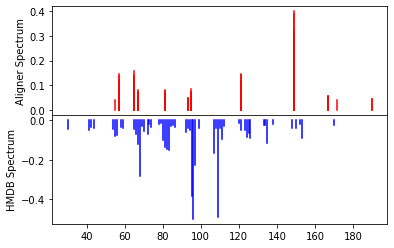

----
NaN  84.0442725231773
['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate', 'l-allo-threonine$l-threonine'] C05519;C00188
M-H4O2+H[1+] : L-Threonine 119.1192 C4H9NO3 C00188 0.35746478621528743


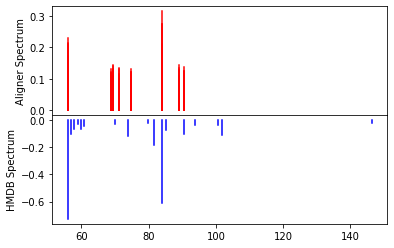

----
NaN  167.08961125424034
['l-phenylalanine$'] C00079;CE2172
----
NaN  494.32407618931364
['cervonyl carnitine'] c226crn
M+HCOOK[1+] : Ezetimibe 409.4252 C24H21F2NO3 None 0.019593888608669674


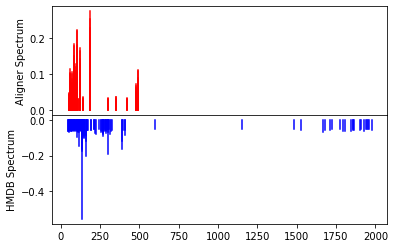

----
NaN  795.6087868430398
NaN NaN
----
NaN  676.546512075571
NaN NaN
----
NaN  119.01619202750072
NaN NaN
M-NH3+H[1+] : Adenine 135.1267 C5H5N5 C00147 0.12236559431728594


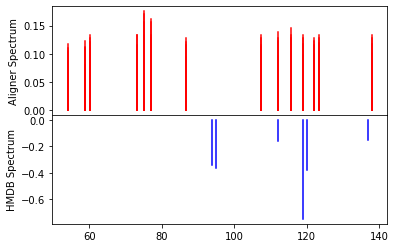

----
NaN  133.03179997983187
['l-methionine'] C00073
----
NaN  813.620170710637
NaN NaN
----
NaN  304.21173236553483
NaN NaN
----
NaN  205.1264040205214
NaN NaN
----
NaN  745.5926278921272
NaN NaN
----
NaN  302.23251875620036
NaN NaN
----
NaN  151.04779716159987
['5,6-dihydrothymine'] C00906
----
NaN  174.08740496279592
['5-guanidino-2-oxopentanoate; 5-guanidino-2-oxo-pentanoate; 2-oxo-5-guanidinopentanoate; 2-oxo-5-guanidino-pentanoate', 'l-histidine'] C00135
----
NaN  142.12273035551368
NaN NaN
M+HCOONa[1+] : Methylguanidine 73.0971 C2H7N3 C02294 0.19577271833854554


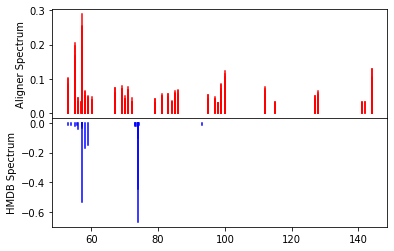

----
NaN  316.24817137787306
NaN NaN
M+Na[1+] : Oxaprozin 293.3166 C18H15NO3 C07356 0.04317296609361367


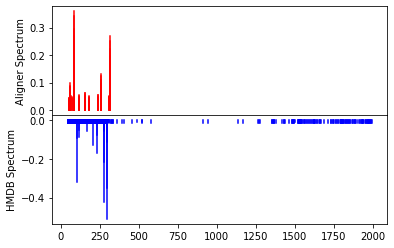

----
NaN  814.6869326139753
NaN NaN
----
NaN  781.5560995434957
NaN NaN
----
NaN  179.127837532445
NaN NaN
----
NaN  219.14204296167347
['propionyl-carnitine'] pcrn
M+H+Na[2+] : Flecainide 414.3427 C17H20F6N2O3 C07001 0.10042931225563559


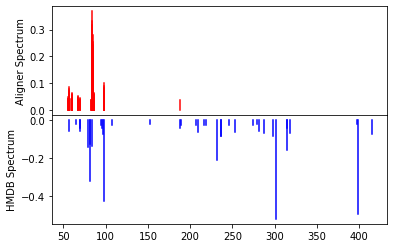

----
NaN  811.60400390625
NaN NaN
----
NaN  230.09579192614947
NaN NaN
----
NaN  744.5532271067302
NaN NaN
----
NaN  815.6969108012186
NaN NaN
----
NaN  773.5876270162648
NaN NaN
----
thymine C00178 127.08659606144346
NaN NaN
----
NaN  283.1034067327326
NaN NaN
----
NaN  701.5587664152448
NaN NaN
----
NaN  288.2168204171317
['l-octanoylcarnitine'] C02838
M+HCOONa[1+] : Pantothenic acid 219.235 C9H17NO5 C00864 0.18538639566943846


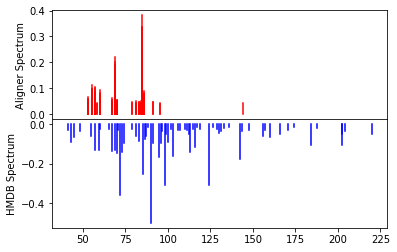

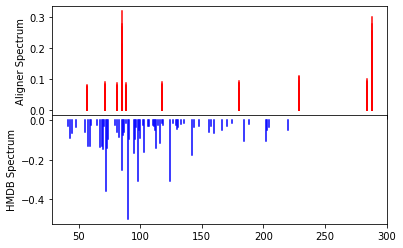

----
NaN  783.5721797688803
NaN NaN
----
NaN  165.11223471792118
NaN NaN
----
NaN  218.13872538114845
['propionyl-carnitine'] pcrn
M+HCOONa[1+] : L-Methionine 149.211 C5H11NO2S C00073 0.06672557098837013


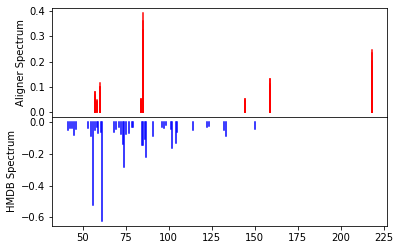

----
NaN  151.06173039825867
['l-methionine'] C00073
----
NaN  808.58344708067
NaN NaN
----
NaN  880.5899320660216
NaN NaN
----
NaN  190.08622629502239
['methyl indole-3-acetate'] CE2122
M+H[1+] : Kynurenic acid 189.1675 C10H7NO3 C01717 0.1489757924972856


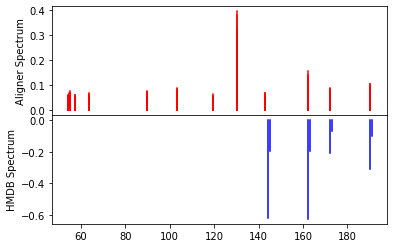

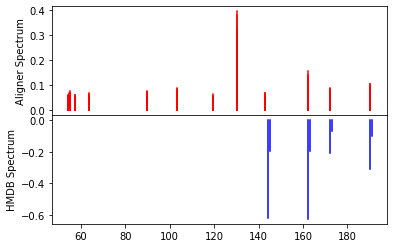

----
NaN  154.07240237611714
NaN NaN
----
NaN  151.0579272576098
NaN NaN
----
nicotinamide  123.05528043445787
['nicotinamide', '3-methylimidazoleacetic acid'] C05828
M+H[1+] : Niacinamide 122.1246 C6H6N2O C00153 0.48447439857309677


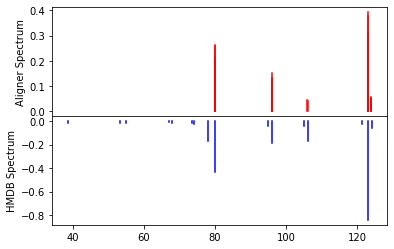

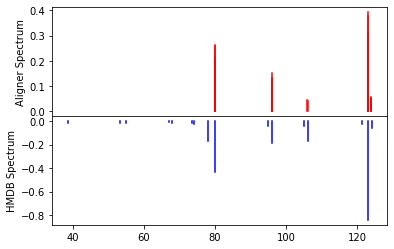

----
NaN  180.15944360431868
NaN NaN
M+HCOONa[1+] : Cytosine 111.102 C4H5N3O C00380 0.16120879782984124


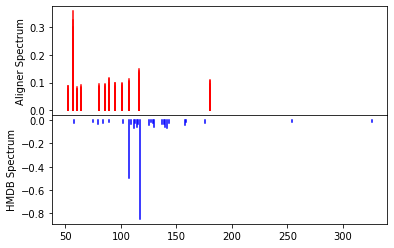

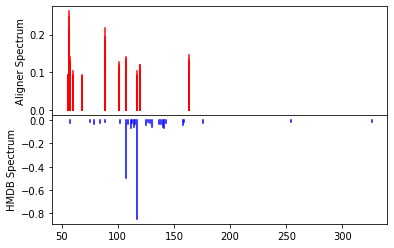

----
NaN  163.13287734985354
NaN NaN
M(C13)+H[1+] : L-Carnitine 161.1989 C7H15NO3 C00318 0.08033472718571145


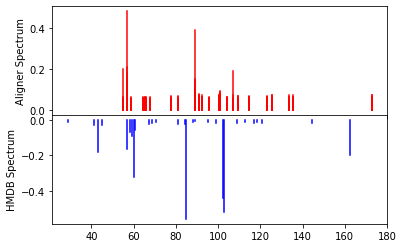

----
NaN  164.136320013749
NaN NaN
----
NaN  518.3220455771998
NaN NaN
----
NaN  239.16410007116932
NaN NaN
----
NaN  190.04985789248818
['4-hydroxy-2-quinolinecarboxylic acid$1-nitronaphthalene-5,6-oxide$1-nitronaphthalene-7,8-oxide', '4-(2-aminophenyl)-2,4-dioxobutanoate'] C01252
----
NaN  275.1033547384697
NaN NaN
M+H2O+H[1+] : Anagrelide 256.088 C10H7Cl2N3O None 0.02990454743138523


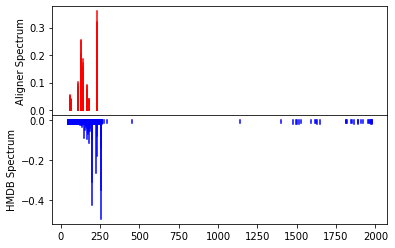

----
NaN  768.5890444402826
NaN NaN
----
NaN  499.34838518415177
NaN NaN
----
NaN  107.07027776617753
['butanoic acid; butanoate; butyrate; butyric acid', '1-methylpyrrolinium'] C06178
----
NaN  234.13358319600425
NaN NaN
----
NaN  172.07971515394237
NaN NaN
----
NaN  203.05238235473632
['d-glucose$beta-d-glucose$l-sorbose; l-xylo-hexulose$beta-d-fructose; beta-fruit sugar; beta-d-arabino-hexulose; beta-levulose; fructose$alpha-d-glucose$d-hexose$$d-fructose$beta-d-galactose$galactose$d-tagatose; lyxo-hexulose$myo-inositol$glucose$d-galactose$alpha-d-galactose$d-mannose'] C00031;C00221;C00247;C02336;C00267;C00738;C00936;C00095;C00962;C01582;C00795;C00137;C00293;C00124;C00984;C00159
M(C13)+2H[2+] : CDP 403.1764 C9H15N3O11P2 C00112 0.034738339793873425


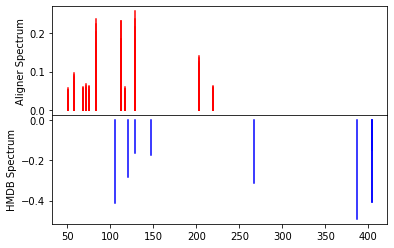

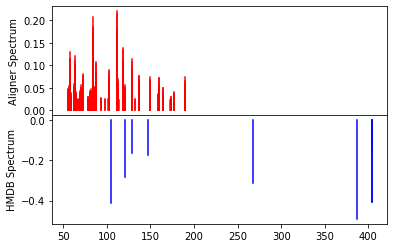

----
NaN  544.3396243533573
NaN NaN
M+K[1+] : Chlorhexidine 505.447 C22H30Cl2N10 C06902 0.14775657142352916


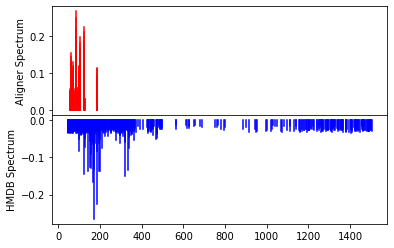

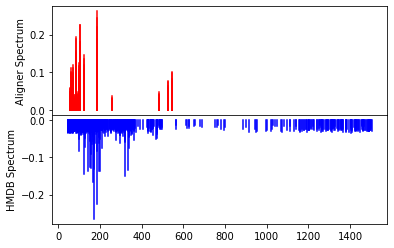

----
NaN  120.06554317474364
['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', 'l-allo-threonine$l-threonine'] C05519;C00188
----
NaN  130.065154281317
['l-phenylalanine$'] C00079;CE2172
----
NaN  301.98991324684835
NaN NaN
----
NaN  424.34192075567734
['linoelaidyl carnitine$linoleyl carnitine'] lneldccrn;lnlccrn
----
NaN  786.6569239298503
NaN NaN
----
NaN  524.3713559602436
['tetracosapentaenoyl carnitine$tetracosapentaenoyl carnitine'] tetpent6crn;tetpent3crn
M+H2O+H[1+] : Chlorhexidine 505.447 C22H30Cl2N10 C06902 0.16485760529262594


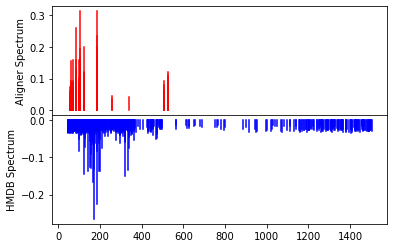

----
glycylglycine  133.06076973362974
['n-carbamoyl-beta-alanine$l-asparagine'] C02642;C00152
M(C13)+H[1+] : Creatine 131.1332 C4H9N3O2 C00300 0.470439438819249


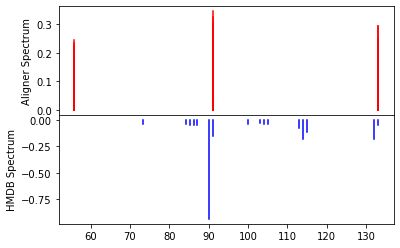

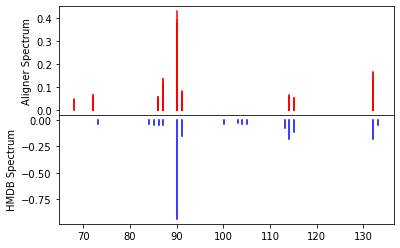

----
NaN  525.3746976350483
NaN NaN
----
NaN  675.5432167590502
NaN NaN
----
NaN  232.1543136395906
NaN NaN
M-NH3+H[1+] : Pyridoxamine 5'-phosphate 248.173 C8H13N2O5P C00647 0.21807208040734907


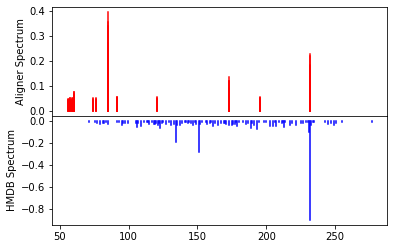

----
NaN  146.08119874251517
['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproate$4-acetamidobutanoate$l-2-aminoadipate 6-semialdehyde; 2-aminoadipate 6-semialdehyde'] C03239;C02946;C04076
M+K[1+] : Benzylamine 107.1531 C7H9N C15562 0.20726022500159397


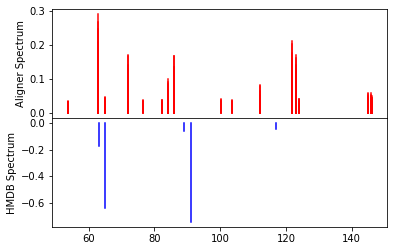

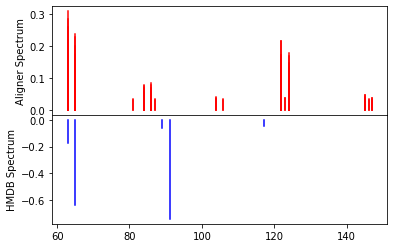

----
NaN  183.11287488435443
NaN NaN
----
NaN  305.25148667229547
NaN NaN
----
NaN  105.11056381908816
NaN NaN
M(C13)+H[1+] : Dimethylglycine 103.1198 C4H9NO2 C01026 0.3707066784256333


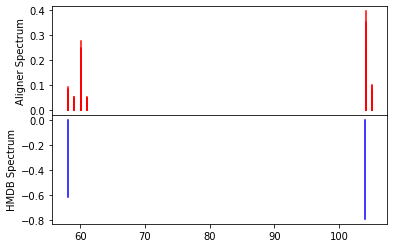

----
NaN  151.0615100315639
NaN NaN
----
NaN  195.0877855535139
NaN NaN
----
NaN  519.3254619397617
NaN NaN
----
NaN  426.3576013776992
['elaidic carnitine$vaccenyl carnitine$octadecenoyl carnitine'] elaidcrn;vacccrn;odecrn
M+NaCl[1+] : Bambuterol 367.44 C18H29N3O5 None 0.02498249949244441


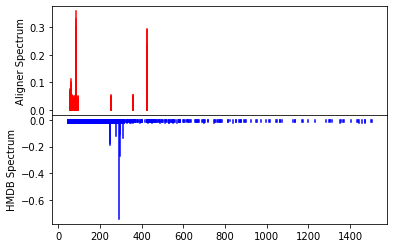

----
NaN  203.1391557392321
NaN NaN
M-NH3+H[1+] : Pantothenic acid 219.235 C9H17NO5 C00864 0.044163572941134675


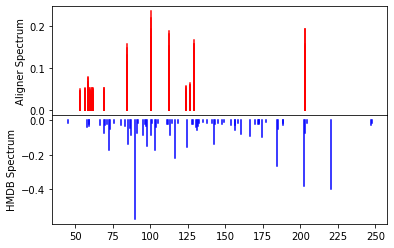

----
ala-gly  147.07640584309897
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', 'n-formimidoyl-l-glutamate'] C00439
----
NaN  273.1858120542584
NaN NaN
----
NaN  199.10779196529063
NaN NaN
----
NaN  744.588998545771
NaN NaN
----
NaN  310.20132788296405
NaN NaN
M(S34)+H[1+] : Nitazoxanide 307.282 C12H9N3O5S None 0.0705082303829487


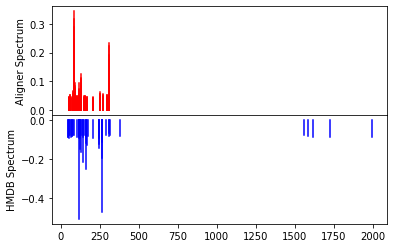

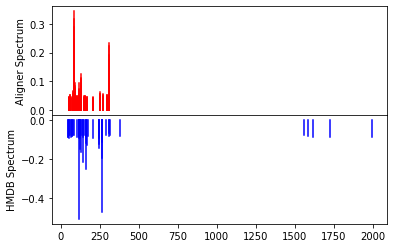

----
NaN  780.5525822358973
NaN NaN
----
NaN  176.07068128988774
['indole-3-acetate$5-hydroxyindoleacetaldehyde', '4-hydroxy-5-phenyltetrahydro-1,3-oxazin-2-one$3-carbamoyl-2-phenylpropionaldehyde'] C16595;C16587
M+H[1+] : N-Acetyl-L-aspartic acid 175.1394 C6H9NO5 C01042 0.08290152897207517


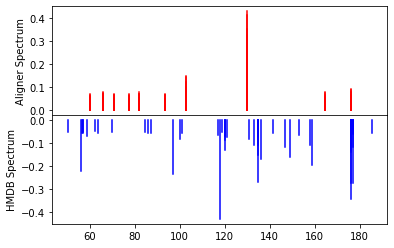

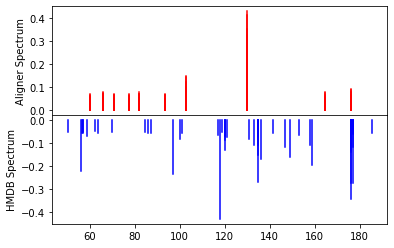

----
NaN  627.535191050747
NaN NaN
----
NaN  204.12314174049786
NaN NaN
----
NaN  188.07065762971573
['l-tryptophan$d-tryptophan', '5-methoxyindoleacetate'] C05660
M-CO2+H[1+] : Guanabenz 231.082 C8H8Cl2N4 C07034 0.09352361151086935


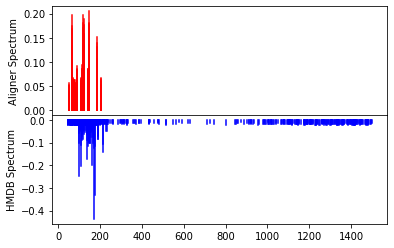

----
NaN  280.2350727026013
NaN NaN
----
NaN  287.0999953746796
['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine'] C04148;C05642
M-NH3+H[1+] : Ethacrynic acid 303.138 C13H12Cl2O4 None 0.04547088683964839


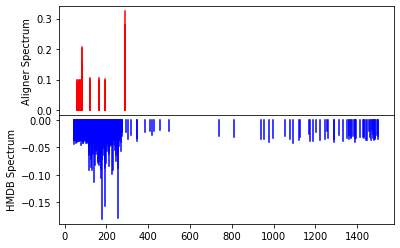

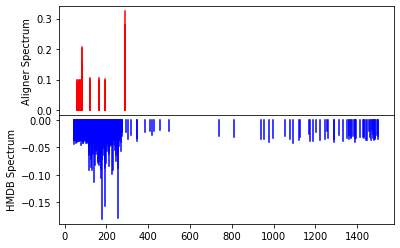

----
NaN  234.01471499739026
NaN NaN
----
NaN  159.07646289624662
['l-citrulline; 2-amino-5-ureidovaleric acid; citrulline'] C00327
M-NH3+H[1+] : Indoleacetic acid 175.184 C10H9NO2 C00954 0.0868220535667204


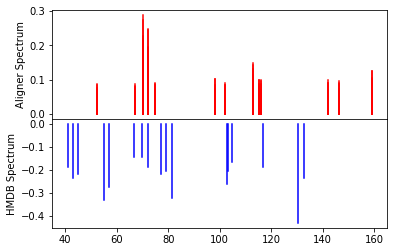

----
NaN  155.106687515501
['nan', 'nan'] CE2577
M+H[1+] : Gentisic acid 154.121 C7H6O4 C00628 0.17949572296694688


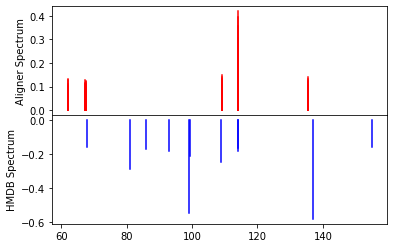

----
NaN  546.3552521599663
NaN NaN
----
NaN  157.0801659634239
['l-histidine'] C00135
----
NaN  314.2324535972194
NaN NaN
M+NaCl[1+] : Diphenhydramine 255.3547 C17H21NO C06960 0.06497665919006089


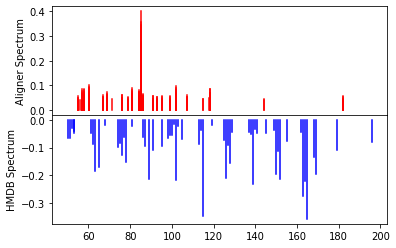

----
NaN  110.0712970934416
['l-histidine', '4-guanidinobutanoate'] C01035
----
NaN  614.5354108418503
NaN NaN
M+HCOOK[1+] : Nilotinib 529.5158 C28H22F3N7O None 0.1357363712973851


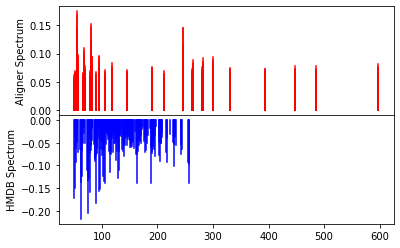

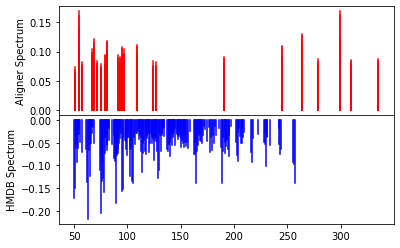

----
NaN  235.08041556936797
NaN NaN
----
NaN  154.058688856151
['creatine; alpha-methylguanidino acetic acid; methylglycocyamine'] C00300
M-H2O+H[1+] : Metronidazole 171.154 C6H9N3O3 C07203 0.11665680942905973


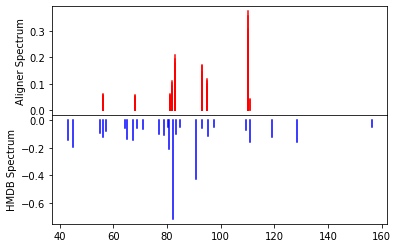

----
NaN  267.17182456122504
NaN NaN
M+NaCl[1+] : L-Kynurenine 208.2139 C10H12N2O3 C00328 0.24639564214363713


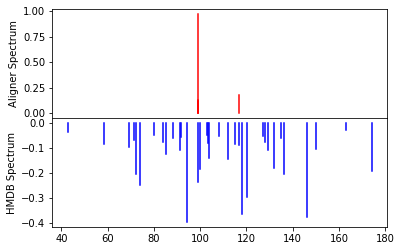

----
NaN  237.05221221026244
NaN NaN
----
l-tryptophan C00078 205.09726213154042
['l-tryptophan$d-tryptophan'] C00078;C00525
M+NaCl[1+] : L-Lysine 146.1876 C6H14N2O2 C00047 0.10341128418954457


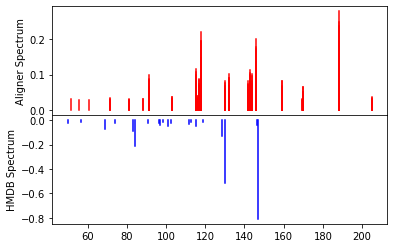

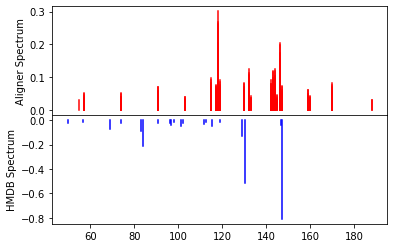

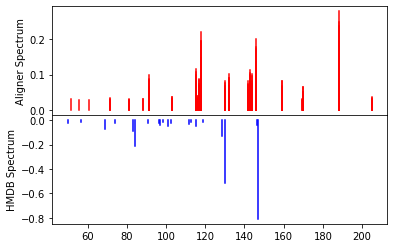

----
NaN  334.29506645828
NaN NaN
----
NaN  115.08663323051051
['ornithine$d-ornithine$ornithine; 2,5-diaminovaleric acid; 2,5-diaminopentanoic acid; 2,5-diaminopentanoate'] C00077;C00515;C01602
----
NaN  575.4667115388094
NaN NaN
----
NaN  206.1005692732961
['l-tryptophan$d-tryptophan'] C00078;C00525
----
NaN  199.0966172987415
NaN NaN
----
NaN  140.01075387001038
NaN NaN
----
NaN  547.35849609375
NaN NaN
----
NaN  558.4730518482351
NaN NaN
----
NaN  801.683343275538
NaN NaN
----
6-methylaminopurine  150.0583741037469
['l-methionine'] C00073
M+H2O+H[1+] : Creatine 131.1332 C4H9N3O2 C00300 0.13012712450217637


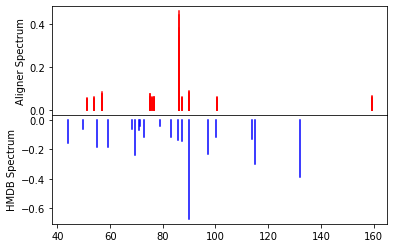

----
NaN  236.07280448175248
NaN NaN
----
l-citrulline  176.1030119845742
['l-citrulline; 2-amino-5-ureidovaleric acid; citrulline'] C00327
M+H[1+] : Indoleacetic acid 175.184 C10H9NO2 C00954 0.16364174247497013


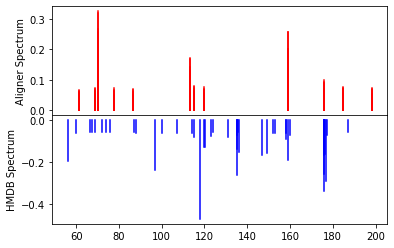

----
NaN  254.0259110734269
NaN NaN
----
NaN  232.11794593117455
NaN NaN
----
NaN  105.07399589137027
['(s)-2-aminobutanoate; (s)-2-aminobutanoic acid; (s)-2-aminobutyric acid$n,n-dimethylglycine; dimethylglycine$4-aminobutanoate$3-aminoisobutyric acid; 3-aminoisobutanoate; 3-amino-2-methylpropanoate$d-3-amino-isobutanoate$l-3-amino-isobutanoate'] C02356;C01026;C00334;C05145;C01205;C03284
M-NH3+H[1+] : L-Cysteine 121.158 C3H7NO2S C00097 0.1807704749261566


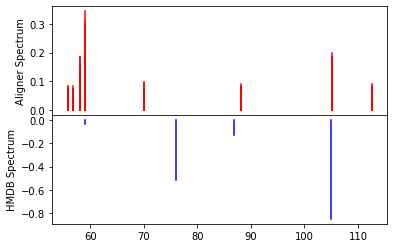

----
NaN  140.06820021735297
['glycine betaine$5-aminopentanoate; 5-aminopentanoic acid; 5-aminovaleric acid$l-valine'] C00719;C00431;C00183
----
NaN  268.14026608674425
NaN NaN
----
NaN  314.2324299812317
NaN NaN
----
NaN  221.1536908663236
NaN NaN
----
NaN  117.09100897270336
['nan'] C08261
----
l-aspartate  134.08102366798806
NaN NaN
----
NaN  212.99954367972708
NaN NaN
----
NaN  177.1063359913073
['l-citrulline; 2-amino-5-ureidovaleric acid; citrulline'] C00327
----
NaN  344.2795088026258
NaN NaN
----
NaN  663.4531615407842
NaN NaN
----
l-serine C00065 106.049880680285
['l-serine$d-serine'] C00065;C00740
----
NaN  521.3433750036991
NaN NaN
----
NaN  317.26857081821987
NaN NaN
M+HCOOK[1+] : Melatonin 232.2783 C13H16N2O2 C01598 0.07254135696406369


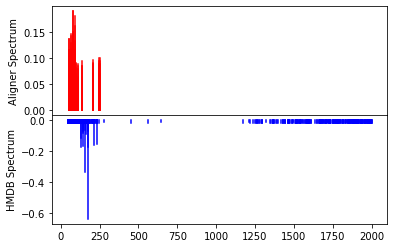

----
NaN  760.5838554783871
NaN NaN
----
NaN  594.5090077718098
NaN NaN
----
NaN  149.1173115292111
NaN NaN
M-NH3+H[1+] : L-Phenylalanine 165.1891 C9H11NO2 C00079 0.1438382563641816


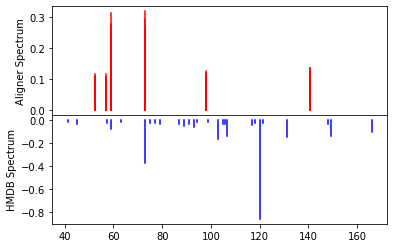

----
NaN  218.13847305525601
['propionyl-carnitine'] pcrn
----
NaN  246.1331817894651
NaN NaN
----
NaN  703.5744416086297
NaN NaN
----
NaN  104.07060181467155
['(s)-2-aminobutanoate; (s)-2-aminobutanoic acid; (s)-2-aminobutyric acid$n,n-dimethylglycine; dimethylglycine$4-aminobutanoate$3-aminoisobutyric acid; 3-aminoisobutanoate; 3-amino-2-methylpropanoate$d-3-amino-isobutanoate$l-3-amino-isobutanoate'] C02356;C01026;C00334;C05145;C01205;C03284
M+H[1+] : Dimethylglycine 103.1198 C4H9NO2 C01026 0.49310053344784593


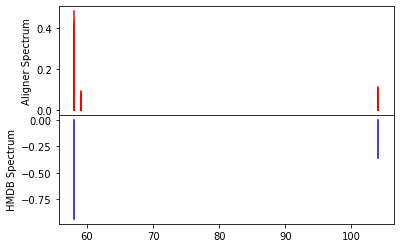

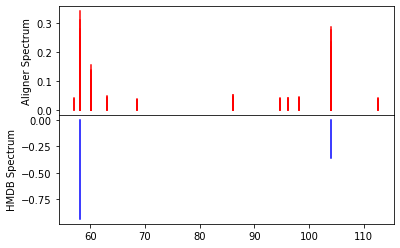

----
NaN  145.10529708862302
NaN NaN
M-C3H4O2+H[1+] : Methoxsalen 216.192 C12H8O4 C01864 0.05369770598638984


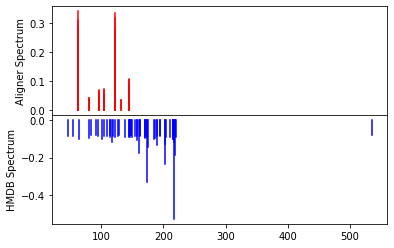

----
NaN  497.3431181907654
NaN NaN
----
NaN  204.12316850934707
NaN NaN
----
NaN  188.1281914089037
NaN NaN
----
NaN  189.12342081571882
['n6-acetyl-l-lysine'] C02727
----
NaN  733.5568319653707
NaN NaN
----
NaN  114.05500411987305
['l-glutamate 5-semialdehyde; l-glutamate gamma-semialdehyde$trans-4-hydroxy-l-proline$5-aminolevulinate; 5-amino-4-oxopentanoate; 5-amino-4-oxovaleric acid$cis-4-hydroxy-d-proline$5-amino-2-oxopentanoic acid; 5-amino-2-oxopentanoate; 2-oxo-5-amino-pentanoate; 2-oxo-5-aminopentanoate; alpha-keto-delta-aminopentanoate; 2-oxo-5-aminovalerate', '1-pyrroline-5-carboxylate$1-pyrroline-2-carboxylate; 1-pyrroline-2-carboxylic acid; delta1-pyrroline 2-carboxylate'] C03912;C03564
M-C3H4O2+H[1+] : Phosphoserine 185.0725 C3H8NO6P C01005 0.2614610622261586


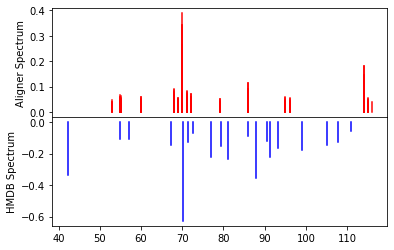

----
NaN  304.24814770672765
NaN NaN
M+H2O+H[1+] : Letrozole 285.3027 C17H11N5 C08163 0.12943727131697655


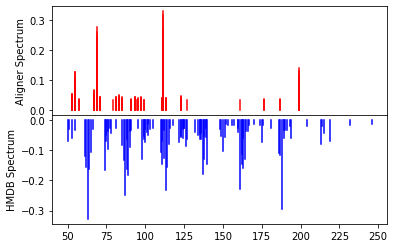

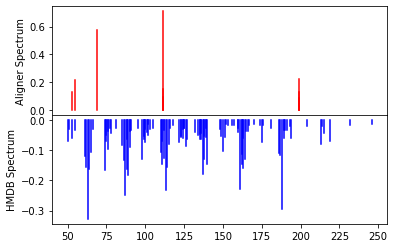

----
NaN  128.07060296194894
['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproate$4-acetamidobutanoate$l-2-aminoadipate 6-semialdehyde; 2-aminoadipate 6-semialdehyde', 'delta1-piperideine-2-carboxylate; 1,2-didehydropiperidine-2-carboxylate$2,3,4,5-tetrahydropyridine-2-carboxylate; delta1-piperideine-6-l-carboxylate'] C04092;C00450
M(C13)+H[1+] : Thymine 126.1133 C5H6N2O2 C00178 0.23823116271666597


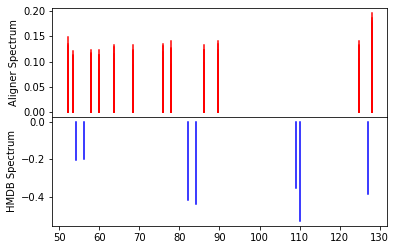

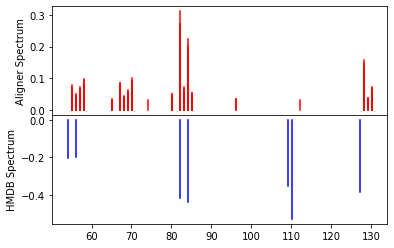

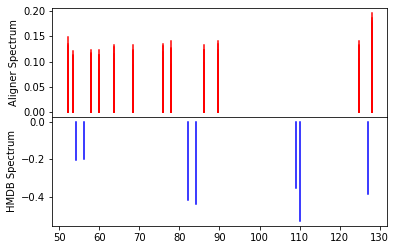

----
NaN  199.1693437937144
NaN NaN
M-C3H4O2+H[1+] : Apigenin 270.2369 C15H10O5 C01477 0.18309510194613526


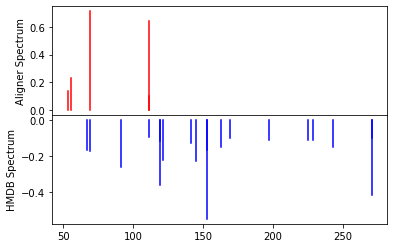

----
NaN  268.1751722063337
NaN NaN
----
NaN  214.09088785140239
NaN NaN
----
NaN  286.20105970228036
NaN NaN
M+HCOOK[1+] : Cysteine-S-sulfate 201.221 C3H7NO5S2 C05824 0.090607976459221


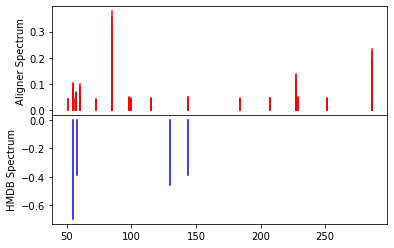

----
NaN  757.6210243918679
NaN NaN
----
NaN  730.5934420498935
NaN NaN
----
NaN  189.0738882767527
NaN NaN
----
NaN  158.11763557227889
NaN NaN
M-NH3+H[1+] : L-Arginine 174.201 C6H14N4O2 C00062 0.17095140329144365


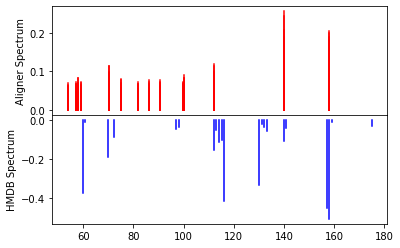

----
NaN  704.5778045654297
NaN NaN
----
NaN  144.10200201946756
NaN NaN
----
l-leucine C00123 132.06189587241724
NaN NaN
----
NaN  761.5877621299343
NaN NaN
----
NaN  597.508512878418
NaN NaN
----
NaN  184.09693105597245
['l-normetanephrine$l-adrenaline; (r)-(-)-adrenaline; (r)-(-)-epinephrine; (r)-(-)-epirenamine; (r)-(-)-adnephrine; 4-[(1r)-1-hydroxy-2-(methylamino)ethyl]-1,2-benzenediol', '(r)-pantothenate'] C00864
----
pyridoxal C00250 168.12307760160263
NaN NaN
M+H[1+] : 3-Methoxytyramine 167.205 C9H13NO2 C05587 0.38368069396450977


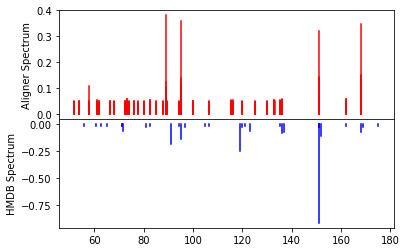

----
NaN  174.1125615437826
['(r)-pantothenate'] C00864
----
NaN  247.09239354626885
NaN NaN
----
NaN  244.19077847455003
NaN NaN
M+H[1+] : Cytidine 243.2166 C9H13N3O5 C02961 0.20734843857986962


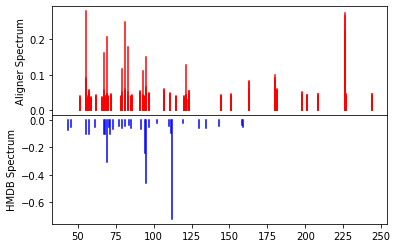

----
NaN  316.24815979003904
NaN NaN
----
NaN  680.4798230622944
NaN NaN
----
NaN  143.0816130802549
NaN NaN
----
NaN  129.06584555203798
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine'] C00906
----
NaN  182.13882136989284
NaN NaN
----
NaN  735.5724169756917
NaN NaN
----
NaN  746.6043352399554
NaN NaN
----
NaN  143.10674122401647
['nan'] C08261
----
NaN  249.1848550684312
NaN NaN
----
NaN  138.0429235346177
['urocanate'] C00785
M(C13)+H[1+] : Hypoxanthine 136.1115 C5H4N4O C00262 0.45321425738539034


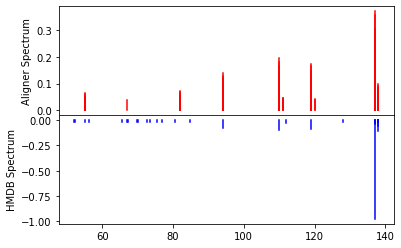

----
NaN  239.14864931608503
NaN NaN
----
NaN  200.1726917521159
NaN NaN
----
NaN  131.08155933179353
NaN NaN
----
NaN  246.12364485457138
NaN NaN
----
NaN  702.562222454999
NaN NaN
----
NaN  178.07238173811402
NaN NaN
M+HCOONa[1+] : Hypotaurine 109.147 C2H7NO2S C00519 0.19174705958238347


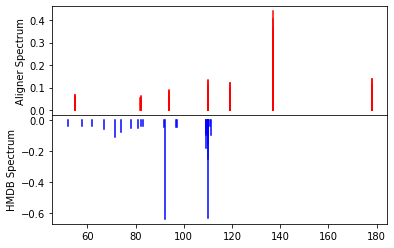

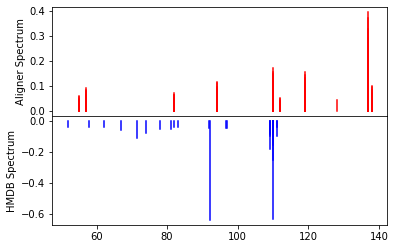

----
NaN  226.180166391226
NaN NaN
M-H2O+H[1+] : Cytidine 243.2166 C9H13N3O5 C02961 0.141532539540134


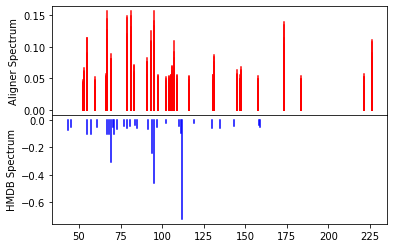

----
NaN  299.25800904231284
['linoleic acid (all cis c18:2) n-6'] C01595
M(C13)+H[1+] : 5'-Methylthioadenosine 297.334 C11H15N5O3S C00170 0.10681616828051778


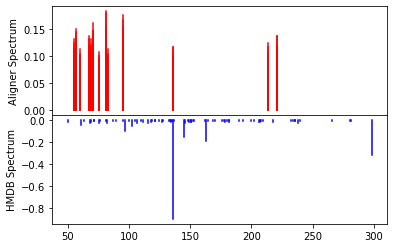

----
NaN  111.11682713826498
NaN NaN
M(C13)+2H[2+] : Pantothenic acid 219.235 C9H17NO5 C00864 0.056759248180725835


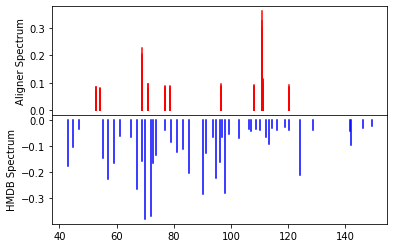

----
NaN  149.06382762363978
['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde'] C00217;C00025;C05938
----
NaN  153.06587871752288
["n1-methyl-2-pyridone-5-carboxamide; n'-methyl-2-pyridone-5-carboxamide; 1-methyl-5-carboxylamide-2-pyridone$n1-methyl-4-pyridone-5-carboxamide; n'-methyl-4-pyridone-5-carboxamide; 1-methyl-4-pyridone-3-carboximide"] C05842;C05843
M(C13)+2H[2+] : Ethacrynic acid 303.138 C13H12Cl2O4 None 0.07879635239184923


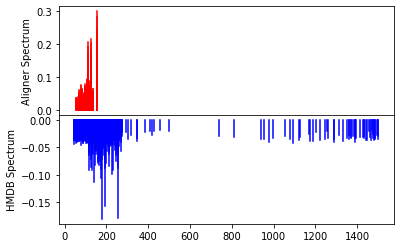

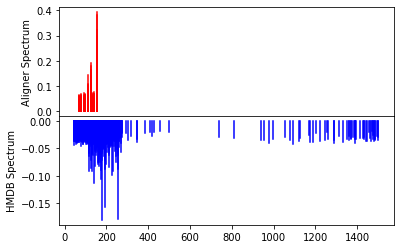

----
NaN  218.21148159629416
NaN NaN
----
NaN  91.05829605303312
['sarcosine; n-methylglycine$l-alanine$beta-alanine$d-alanine'] C00213;C00041;C00099;C00133
----
NaN  195.1228214317644
NaN NaN
----
NaN  134.08116902531805
NaN NaN
M+H[1+] : L-Aspartic acid 133.1027 C4H7NO4 C00049 0.20020006481630764


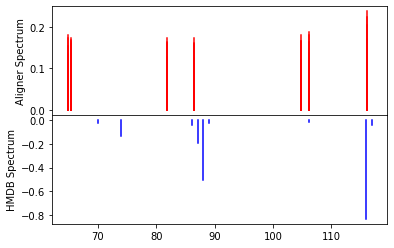

----
NaN  200.0543655189308
NaN NaN
----
NaN  236.07285153865814
NaN NaN
----
4-(beta-acetylaminoethyl)imidazole  154.06922872442948
["n1-methyl-2-pyridone-5-carboxamide; n'-methyl-2-pyridone-5-carboxamide; 1-methyl-5-carboxylamide-2-pyridone$n1-methyl-4-pyridone-5-carboxamide; n'-methyl-4-pyridone-5-carboxamide; 1-methyl-4-pyridone-3-carboximide"] C05842;C05843
----
NaN  732.5535802706868
NaN NaN
----
l-alanine C00041 90.05497520848324
['sarcosine; n-methylglycine$l-alanine$beta-alanine$d-alanine'] C00213;C00041;C00099;C00133
----
NaN  242.2840959649337
NaN NaN
M+K[1+] : L-Acetylcarnitine 203.238 C9H17NO4 None 0.024465503561873526


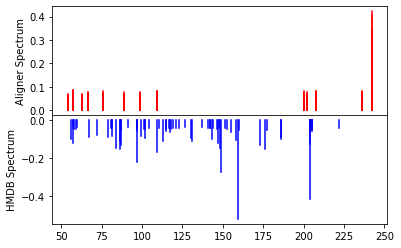

----
NaN  160.09684693185906
['6-acetamido-2-oxohexanoate; 2-oxo-6-acetamidocaproate', '5-acetamidopentanoate'] C03087
M-HCOOH+H[1+] : Xanthurenic acid 205.1669 C10H7NO4 C02470 0.08824028684743537


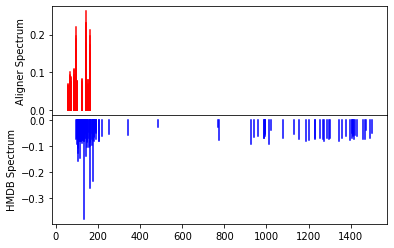

----
NaN  248.14916821183832
NaN NaN
----
NaN  265.11811306602084
['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine'] C04148;C05642
M+Na[1+] : Thymidine 242.2286 C10H14N2O5 C00214 0.12086212434665371


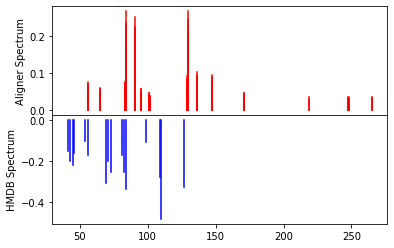

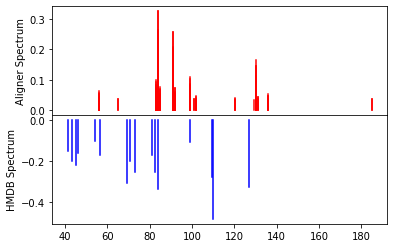

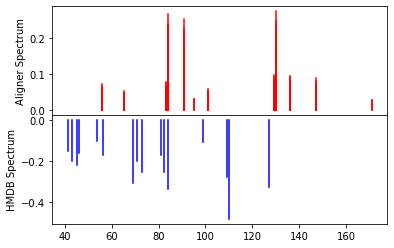

----
4-trimethylammoniobutanoate  146.09245501624213
['5-guanidino-2-oxopentanoate; 5-guanidino-2-oxo-pentanoate; 2-oxo-5-guanidinopentanoate; 2-oxo-5-guanidino-pentanoate', '4-guanidinobutanoate'] C01035
M+K[1+] : Benzylamine 107.1531 C7H9N C15562 0.06536021510317565


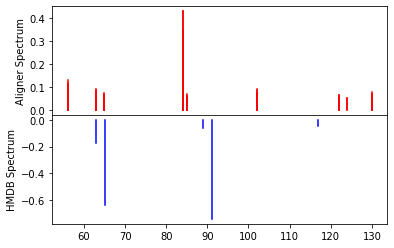

----
NaN  344.22783126831047
NaN NaN
M+K[1+] : Zaleplon 305.3339 C17H15N5O C07484 0.020745006652729936


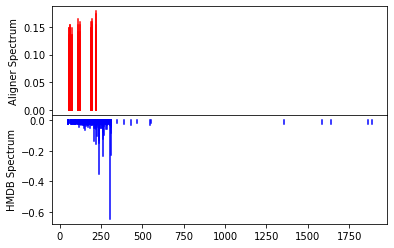

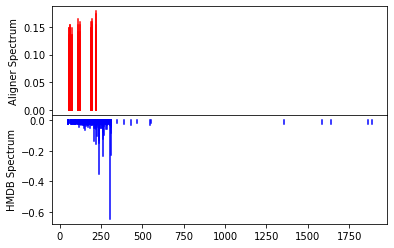

----
NaN  175.00174867784654
['hypoxanthine'] C00262
M(C13)+3H[3+] : Beclometasone dipropionate 521.042 C28H37ClO7 C07813 0.12953464362644115


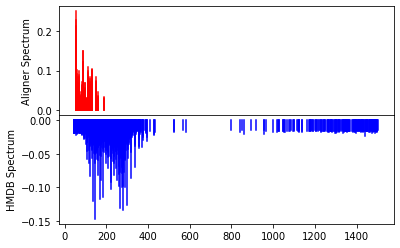

----
adenine C00147 136.04823260240153
['nan'] C00791
M+H[1+] : Adenine 135.1267 C5H5N5 C00147 0.2994606386011165


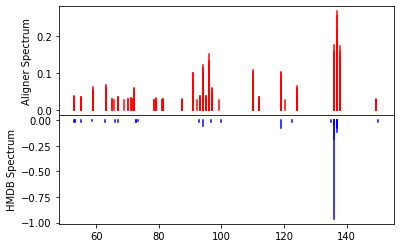

----
NaN  239.12776327824244
NaN NaN
----
NaN  204.95096496055862
NaN NaN
----
NaN  232.1179187877758
NaN NaN
----
NaN  87.07891917228699
NaN NaN
----
NaN  163.1158139078241
NaN NaN
----
NaN  664.4566946847099
NaN NaN
----
NaN  138.04918062364732
['hypoxanthine'] C00262
----
NaN  729.5899542150363
NaN NaN
----
NaN  164.1194361636513
NaN NaN
----
NaN  315.23586303710937
NaN NaN
----
NaN  209.1536945615496
NaN NaN
M+H[1+] : L-Kynurenine 208.2139 C10H12N2O3 C00328 0.236623927125773


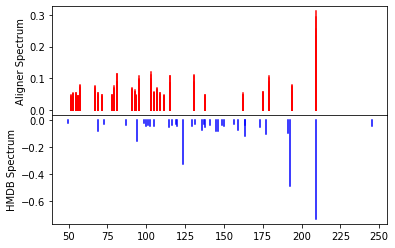

----
NaN  159.0277862548828
['hypoxanthine'] C00262
M+HCOOK[1+] : 1,3-Diaminopropane 74.1249 C3H10N2 C00986 0.09799349800812227


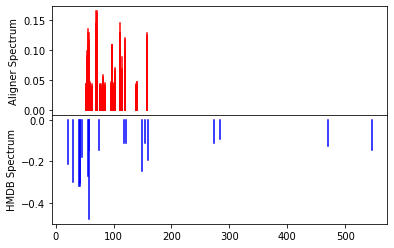

----
NaN  266.12151918572897
['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine'] C04148;C05642
----
o-acetyl-l-serine  148.06041998612253
['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate', 'd-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', '5-oxo-l-proline', 'dl-glutamate; dl-glutaminic acid; 2-aminoglutaric acid; glutamate'] C00302
----
NaN  329.17396462930213
NaN NaN
----
NaN  133.09902106391058
NaN NaN
M-NH3+H[1+] : L-Methionine 149.211 C5H11NO2S C00073 0.18726792114039784


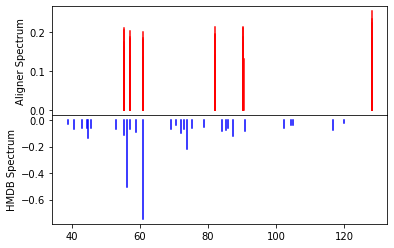

----
betaine C00719 118.0498737700998
['l-aspartate 4-semialdehyde; aspartate beta-semialdehyde; l-aspartic 4-semialdehyde$l-2-amino-3-oxobutanoic acid; l-2-amino-3-oxobutanoate; l-2-amino-acetoacetate; (s)-2-amino-3-oxobutanoic acid$2-amino-3-oxobutanoate; 2-amino-acetoacetate'] C00441;C03508;C03214
----
NaN  184.09689919607982
['l-phenylalanine$', 'l-normetanephrine$l-adrenaline; (r)-(-)-adrenaline; (r)-(-)-epinephrine; (r)-(-)-epirenamine; (r)-(-)-adnephrine; 4-[(1r)-1-hydroxy-2-(methylamino)ethyl]-1,2-benzenediol', '(r)-pantothenate'] C00864
----
NaN  187.09654182111717
['n-trimethyl-2-aminoethylphosphonate; 2-trimethylaminoethylphosphonate'] C06459
----
NaN  289.05334899902346
NaN NaN
----
NaN  163.10959444547953
NaN NaN
M(C13)+H[1+] : L-Carnitine 161.1989 C7H15NO3 C00318 0.47296200959780416


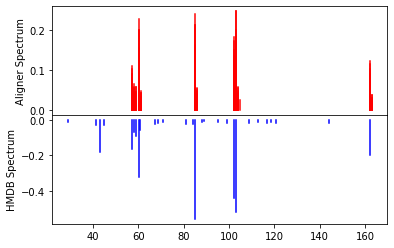

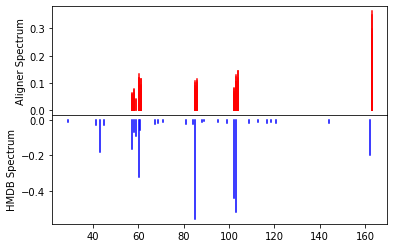

----
NaN  256.17532649793117
NaN NaN
----
NaN  619.4907287597656
NaN NaN
----
NaN  610.5042018605702
NaN NaN
----
NaN  343.29546718910086
NaN NaN
----
NaN  249.06096201578774
NaN NaN
----
NaN  236.07293174050068
NaN NaN
----
NaN  171.1016386783484
['nan'] C08261
----
glycylglycine  133.06886759440104
['l-glutamate 5-semialdehyde; l-glutamate gamma-semialdehyde$trans-4-hydroxy-l-proline$5-aminolevulinate; 5-amino-4-oxopentanoate; 5-amino-4-oxovaleric acid$cis-4-hydroxy-d-proline$5-amino-2-oxopentanoic acid; 5-amino-2-oxopentanoate; 2-oxo-5-amino-pentanoate; 2-oxo-5-aminopentanoate; alpha-keto-delta-aminopentanoate; 2-oxo-5-aminovalerate'] C01165;C01157;C00430;C03440;C01110
----
NaN  164.11646431370787
NaN NaN
----
NaN  592.4934650577911
NaN NaN
----
NaN  194.09249003092447
NaN NaN
M+HCOONa[1+] : Taurine 125.147 C2H7NO3S C00245 0.15994293805377247


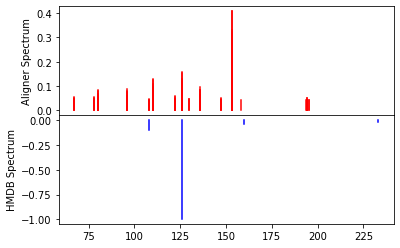

----
o-acetylcarnitine  204.12314158121742
NaN NaN
M-NH3+H[1+] : 5-Hydroxy-L-tryptophan 220.2246 C11H12N2O3 C00643 0.30928836333069604


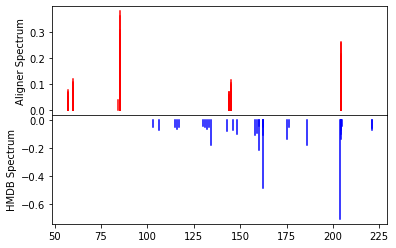

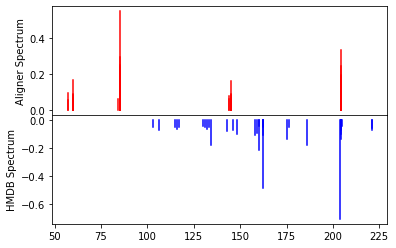

----
NaN  297.24240404939
['13(s)-hode; (13s)-hydroxyoctadecadienoic acid; (9z, 11e)-(13s)-13-hydroxyoctadeca-9,11-dienoic acid$12(13)-epome; (12r,13s)-(9z)-12,13-epoxyoctadecenoic acid$9(10)-epome; (9r,10s)-(12z)-9,10-epoxyoctadecenoic acid'] C14762;C14826;C14825
----
NaN  125.09614275322586
NaN NaN
----
NaN  342.2638501619038
NaN NaN
M+K[1+] : Scopolamine 303.3529 C17H21NO4 C01851 0.05756820764446784


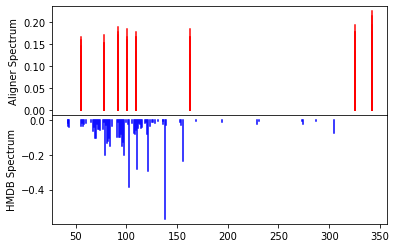

----
NaN  613.523046875
NaN NaN
----
NaN  214.25295069597766
NaN NaN
M+HCOONa[1+] : Spermidine 145.2459 C7H19N3 C00315 0.1962313414048188


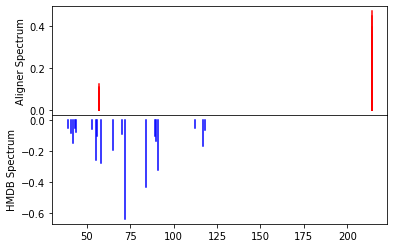

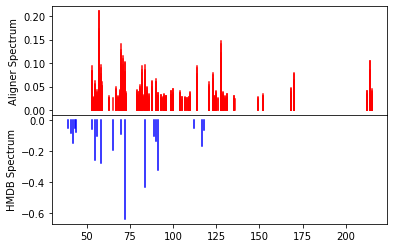

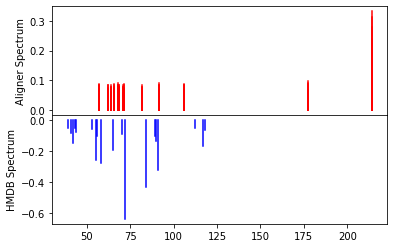

----
NaN  133.105275706241
['l-leucine$l-isoleucine'] C00123;C00407
----
l-leucine C00123 132.10193634033206
['5-acetamidopentanoate', 'l-leucine$l-isoleucine'] C00123;C00407
M+H2O+H[1+] : Creatinine 113.1179 C4H7N3O C00791 0.1884083113490621


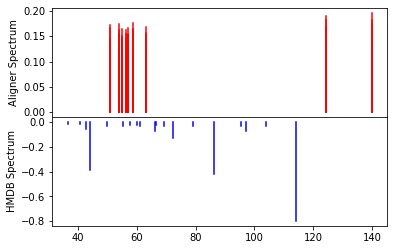

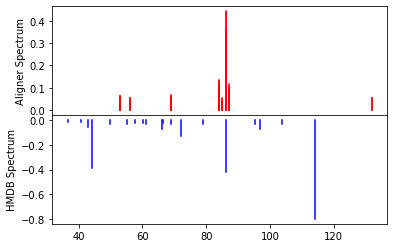

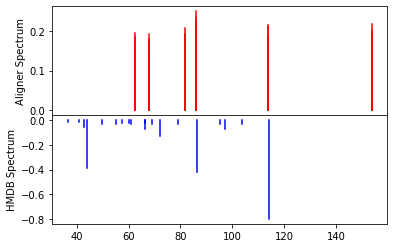

----
NaN  185.11738916345544
NaN NaN
M-NH3+H[1+] : Cysteine-S-sulfate 201.221 C3H7NO5S2 C05824 0.12045790325959999


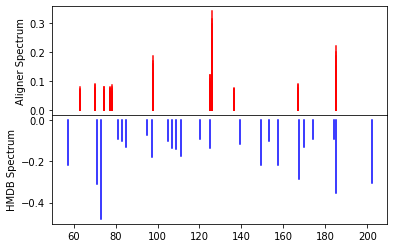

----
NaN  229.15470183523084
NaN NaN
----
NaN  180.0655281278822
['4-(2-aminophenyl)-2,4-dioxobutanoate', 'adrenochrome$hippurate; hippuric acid; n-benzoylglycine; benzoylaminoacetic acid', '3,4-dihydroxy-l-phenylalanine'] C00355
M+HCOONa[1+] : Cytosine 111.102 C4H5N3O C00380 0.10395730404474371


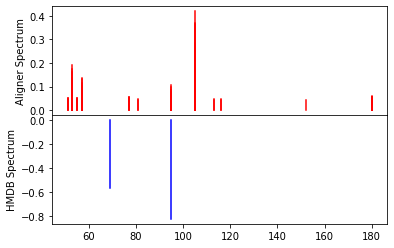

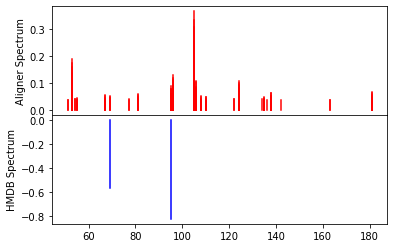

----
NaN  188.12816047668457
NaN NaN
----
NaN  138.05500683031585
['anthranilate'] C00108
----
NaN  239.1389049730804
NaN NaN
M-CO2+H[1+] : Niflumic Acid 282.218 C13H9F3N2O2 C13698 0.23138590839910853


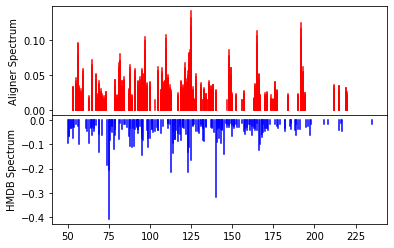

----
NaN  180.0655677951112
['adrenochrome$hippurate; hippuric acid; n-benzoylglycine; benzoylaminoacetic acid', '3,4-dihydroxy-l-phenylalanine'] C00355
----
NaN  160.13324591231674
NaN NaN
----
NaN  705.5815345362613
NaN NaN
----
NaN  816.7016869906721
NaN NaN
----
NaN  595.4927832760027
NaN NaN
----
NaN  217.12954351637097
NaN NaN
----
NaN  763.5949494332979
NaN NaN
----
NaN  128.0706107003348
['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproate$4-acetamidobutanoate$l-2-aminoadipate 6-semialdehyde; 2-aminoadipate 6-semialdehyde', 'delta1-piperideine-2-carboxylate; 1,2-didehydropiperidine-2-carboxylate$2,3,4,5-tetrahydropyridine-2-carboxylate; delta1-piperideine-6-l-carboxylate'] C04092;C00450
----
NaN  198.11256075577
['l-metanephrine'] C05588
----
5-oxoproline  130.08632418983862
['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] C05936;C00408
M+H[1+] : Pipecolic acid 129.157 C6H11NO2 C00408 0.4512639423152608


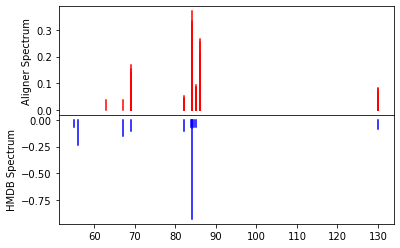

----
NaN  202.18019206488307
NaN NaN
M+HCOOK[1+] : Betaine 117.1463 C5H11NO2 C00719 0.12153557200593802


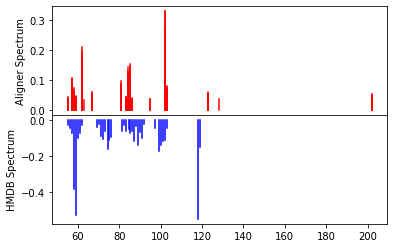

----
NaN  139.05026079260784
['4-imidazolone-5-propanoate', 'urocanate'] C00785
----
NaN  175.10780896638568
['n2-acetyl-l-ornithine'] C00437
----
NaN  159.1573577649666
NaN NaN
----
l-tyrosine C00082 182.08128105966668
['l-tyrosine$'] C00082;CE2174
M+NaCl[1+] : Nicotinic acid 123.1094 C6H5NO2 C00253 0.07232041159474246


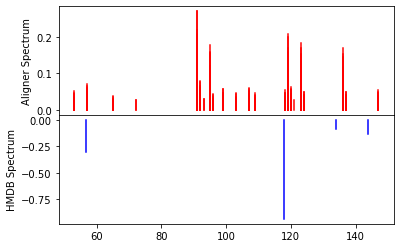

----
NaN  225.14854845319482
NaN NaN
----
NaN  181.1627715858253
NaN NaN
----
methylcysteine None 136.07574593393426
['dopamine', 'l-tyrosine$', '2-phenylacetamide$n-acetylarylamine'] C02505;C02558
----
NaN  253.1545697064467
NaN NaN
----
NaN  132.0655572221086
['l-glutamate 5-semialdehyde; l-glutamate gamma-semialdehyde$trans-4-hydroxy-l-proline$5-aminolevulinate; 5-amino-4-oxopentanoate; 5-amino-4-oxovaleric acid$cis-4-hydroxy-d-proline$5-amino-2-oxopentanoic acid; 5-amino-2-oxopentanoate; 2-oxo-5-amino-pentanoate; 2-oxo-5-aminopentanoate; alpha-keto-delta-aminopentanoate; 2-oxo-5-aminovalerate', '1-pyrroline-5-carboxylate$1-pyrroline-2-carboxylate; 1-pyrroline-2-carboxylic acid; delta1-pyrroline 2-carboxylate', '2-amino-4-oxopentanoic acid; 2-amino-4-oxopentanoate'] C03341
M+NaCl[1+] : Methylguanidine 73.0971 C2H7N3 C02294 0.26857192516676226


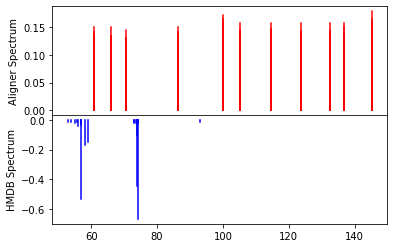

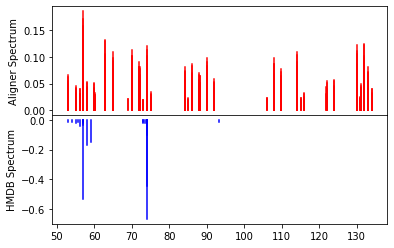

----
NaN  186.1125254380076
['3-methoxytyramine$epinine; deoxyepinephrine'] C05587;C07453
----
NaN  173.12855569939862
NaN NaN
M+NaCl[1+] : Dihydrouracil 114.1026 C4H6N2O2 C00429 0.13278314373475208


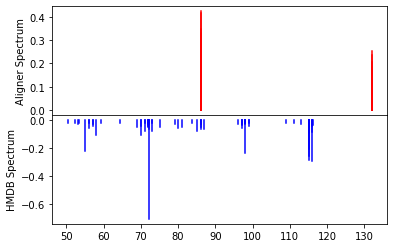

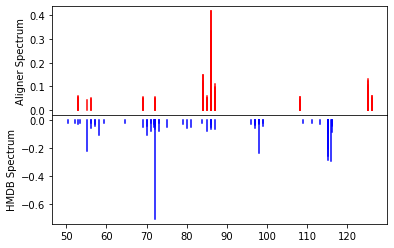

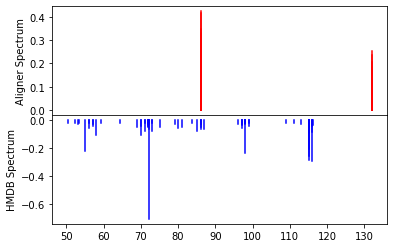

----
creatinine C00791 114.09845822477993
NaN NaN
M+H[1+] : Creatinine 113.1179 C4H7N3O C00791 0.5650537161209404


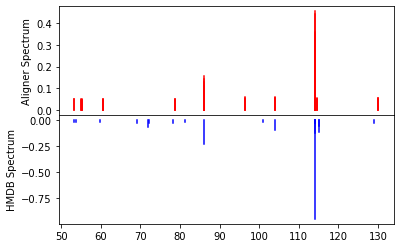

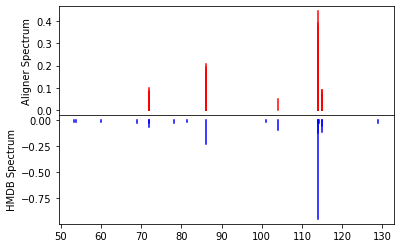

----
eflornithine  183.0845960315905
['l-tyrosine$'] C00082;CE2174
----
glycylglycine  133.0737957201506
NaN NaN
M+H2O+H[1+] : Dihydrouracil 114.1026 C4H6N2O2 C00429 0.03175605971656128


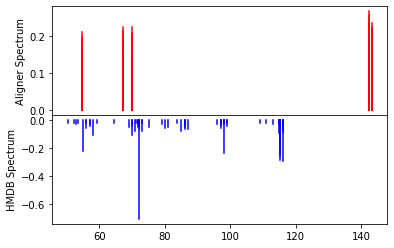

----
NaN  229.15466378864483
NaN NaN
M+H2O+H[1+] : 1,3,7-Trimethyluric acid 210.19 C8H10N4O3 C16361 0.07477803840137465


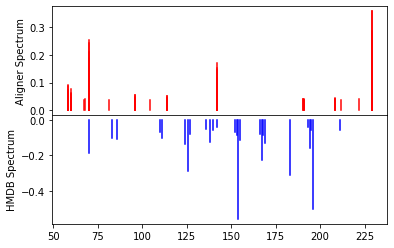

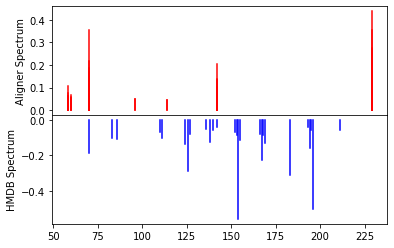

----
glycylglycine  133.08009980854234
['creatine; alpha-methylguanidino acetic acid; methylglycocyamine'] C00300
----
NaN  156.0768249099319
['5-guanidino-2-oxopentanoate; 5-guanidino-2-oxo-pentanoate; 2-oxo-5-guanidinopentanoate; 2-oxo-5-guanidino-pentanoate', 'l-histidine'] C00135
M+H[1+] : L-Histidine 155.1546 C6H9N3O2 C00135 0.4576470901474791


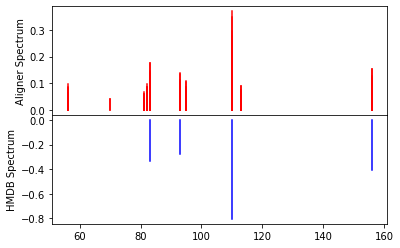

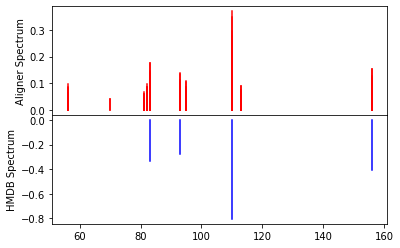

----
NaN  124.08699295737527
['n(pi)-methyl-l-histidine; 1-methylhistidine; n-pros-methyl-l-histidine'] C01152
----
NaN  158.08122460047403
NaN NaN
----
NaN  272.1854264479417
NaN NaN
----
glycine C00037 76.03931125841643
['glycine'] C00037
----
NaN  762.591349283854
NaN NaN
----
NaN  260.1854917611649
NaN NaN
----
NaN  170.1176111433241
['l-metanephrine'] C05588
----
NaN  265.11813668643725
['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine'] C04148;C05642
----
NaN  286.2010930727606
NaN NaN
----
NaN  161.09209030552915
NaN NaN
----
NaN  202.14387217203773
NaN NaN
----
6-methylaminopurine  150.11252065022788
NaN NaN
M-H4O2+H[1+] : Phosphoserine 185.0725 C3H8NO6P C01005 0.21388227581797997


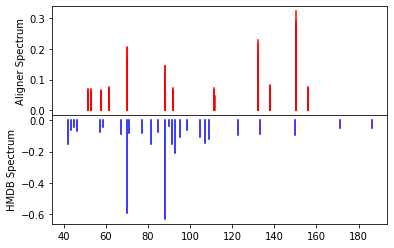

----
NaN  785.6511273451255
NaN NaN
----
NaN  130.04989466947669
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate$5-oxo-l-proline', 'd-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde'] C00217;C00025;C05938
----
NaN  162.07612001723137
['l-2-aminoadipate; l-alpha-aminoadipate; l-alpha-aminoadipic acid; l-2-aminoadipic acid; l-2-aminohexanedioate', 'd-glucosamine'] C00329
----
NaN  148.09682331914487
NaN NaN
----
NaN  89.05965290898862
['butanoic acid; butanoate; butyrate; butyric acid'] C00246
M-NH3+H[1+] : L-Serine 105.0926 C3H7NO3 C00065 0.20063999041088962


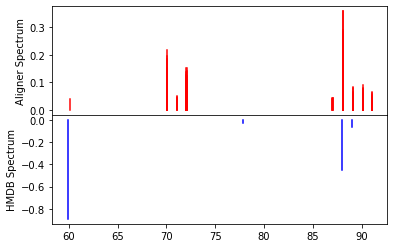

----
NaN  165.05470225685522
['l-tyrosine$', 'cis-2-hydroxycinnamate; 2-coumarinate$4-coumarate; p-coumaric acid; trans-4-hydroxycinnamate; trans-p-hydroxycinnamate; 4-hydroxycinnamic acid; 4-hydroxycinnamate$enol-phenylpyruvate$phenylpyruvate', '3-methoxy-4-hydroxyphenylglycolaldehyde$homovanillate; homovanillic acid'] C05583;C05582
M+2H[2+] : Diloxanide 328.147 C14H11Cl2NO4 C07637 0.10268839373798774


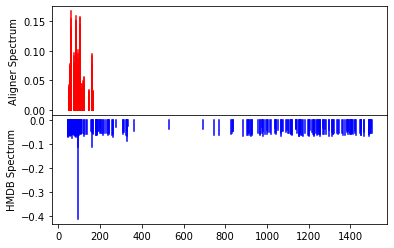

----
NaN  139.05022109182258
['n-formimidoyl-l-glutamate', '4-imidazolone-5-propanoate', 'urocanate'] C00785
M+H[1+] : Urocanic acid 138.124 C6H6N2O2 C00785 0.38892846154212596


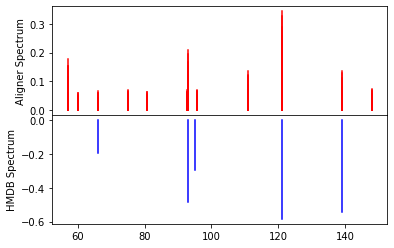

----
NaN  261.120855102539
NaN NaN
M(C13)+H[1+] : Lofexidine 259.132 C11H12Cl2N2O None 0.10366480189945029


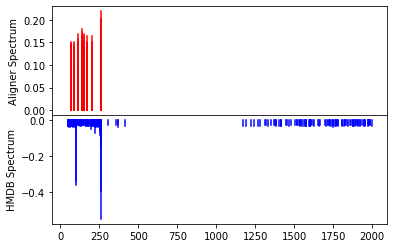

----
o-acetyl-l-serine  148.09682637532552
NaN NaN
----
NaN  131.08965452093827
['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] C05936;C00408
----
NaN  248.14733586166844
NaN NaN
----
NaN  144.10195886521112
NaN NaN
----
NaN  213.09843031026543
NaN NaN
----
NaN  212.09516548623844
NaN NaN
M+Na[1+] : Kynurenic acid 189.1675 C10H7NO3 C01717 0.06490234096502387


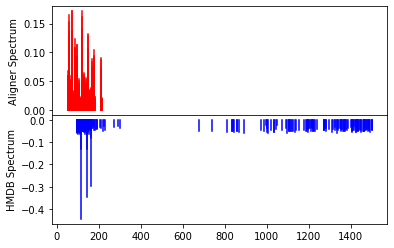

----
5-oxoproline  130.08632408945184
['l-lysine', 'n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] C05936;C00408
M+H[1+] : Pipecolic acid 129.157 C6H11NO2 C00408 0.45041260904129243


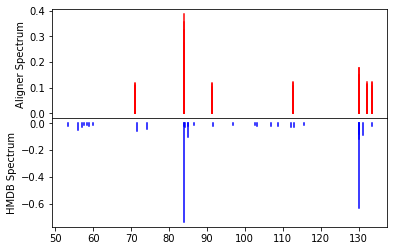

----
NaN  157.09724405649547
['n2-acetyl-l-ornithine'] C00437
----
NaN  281.24732427727685
['linoleic acid (all cis c18:2) n-6'] C01595
----
creatinine C00791 114.05503110324636
['l-glutamate 5-semialdehyde; l-glutamate gamma-semialdehyde$trans-4-hydroxy-l-proline$5-aminolevulinate; 5-amino-4-oxopentanoate; 5-amino-4-oxovaleric acid$cis-4-hydroxy-d-proline$5-amino-2-oxopentanoic acid; 5-amino-2-oxopentanoate; 2-oxo-5-amino-pentanoate; 2-oxo-5-aminopentanoate; alpha-keto-delta-aminopentanoate; 2-oxo-5-aminovalerate', '1-pyrroline-5-carboxylate$1-pyrroline-2-carboxylate; 1-pyrroline-2-carboxylic acid; delta1-pyrroline 2-carboxylate'] C03912;C03564
----
NaN  262.1436151203356
NaN NaN
M-CO2+H[1+] : Melphalan 305.2 C13H18Cl2N2O2 C07122 0.08293503117997611


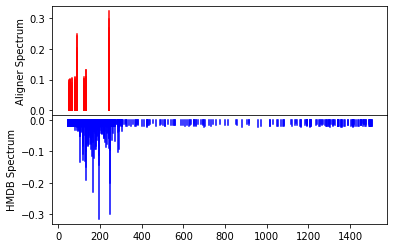

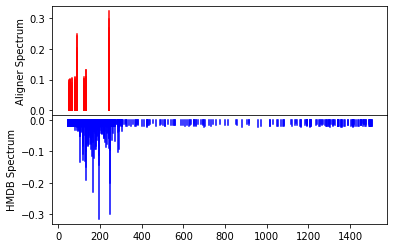

----
NaN  288.22485330369733
NaN NaN
----
NaN  186.1126770019532
NaN NaN
----
NaN  129.12738413206287
NaN NaN
----
NaN  216.12311115670715
['l-metanephrine'] C05588
----
NaN  146.1176025658323
['propionyl-carnitine', '3-dehydroxycarnitine'] C05543
----
NaN  482.36055799211766
NaN NaN
----
NaN  327.1583143535413
NaN NaN
M+HCOOK[1+] : Thymidine 242.2286 C10H14N2O5 C00214 0.06529542805001141


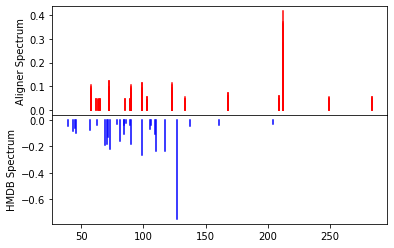

----
NaN  332.33102329799107
NaN NaN
M-CO2+H[1+] : Gatifloxacin 375.3941 C19H22FN3O4 C07661 0.10459205175803042


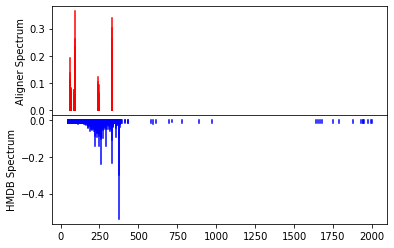

----
NaN  166.08633321126302
['l-phenylalanine$', 'l-normetanephrine$l-adrenaline; (r)-(-)-adrenaline; (r)-(-)-epinephrine; (r)-(-)-epirenamine; (r)-(-)-adnephrine; 4-[(1r)-1-hydroxy-2-(methylamino)ethyl]-1,2-benzenediol'] C05589;C00788
----
NaN  205.1435591045179
NaN NaN
M+H[1+] : L-Tryptophan 204.2252 C11H12N2O2 C00078 0.14504593789907727


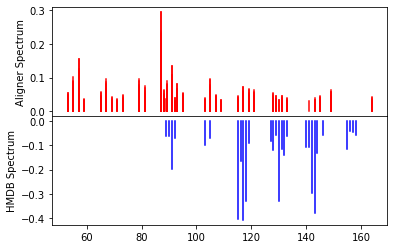

----
NaN  201.11224090576167
['propionyl-carnitine'] pcrn
----
NaN  114.0662480743838
['creatine; alpha-methylguanidino acetic acid; methylglycocyamine', 'nan'] C00791
----
NaN  272.1854494695794
NaN NaN
M(C13)+H[1+] : Apigenin 270.2369 C15H10O5 C01477 0.1564273821698405


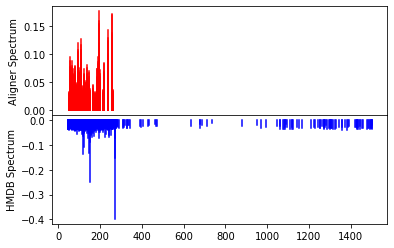

----
NaN  160.13329997815583
NaN NaN
----
NaN  774.5984905890698
NaN NaN
----
NaN  157.06084391945288
['n-formimidoyl-l-glutamate', '4-imidazolone-5-propanoate', 'urocanate'] C00785
M+H[1+] : Orotic acid 156.0963 C5H4N2O4 C00295 0.1466637521194506


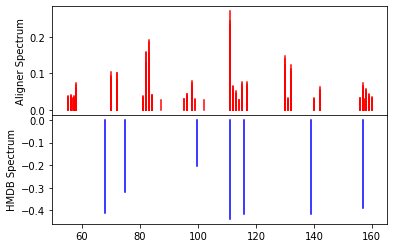

----
NaN  231.13393944188167
NaN NaN
M+HCOOK[1+] : L-Lysine 146.1876 C6H14N2O2 C00047 0.07561490764833861


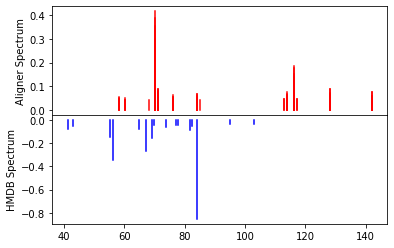

----
NaN  198.08741019753845
NaN NaN
----
NaN  158.1005857367265
NaN NaN
----
NaN  223.0965493854724
NaN NaN
----
NaN  222.17004153603008
NaN NaN
----
betaine C00719 118.0747901013023
NaN NaN
----
NaN  113.05967390877859
['4-methyl-2-oxopentanoate$adipate semialdehyde; hexan-1-one-6-carboxylate; 6-oxohexanoate$3-methyl-2-oxopentanoate; 2-oxo-3-methylvalerate', 'trans-1,2-dihydrobenzene-1,2-diol'] C04221
----
NaN  141.065876910561
['3-methylimidazoleacetic acid'] C05828
----
NaN  328.1617032564603
NaN NaN
----
NaN  246.1699047088623
NaN NaN
M+HCOOK[1+] : L-Carnitine 161.1989 C7H15NO3 C00318 0.31933523743125214


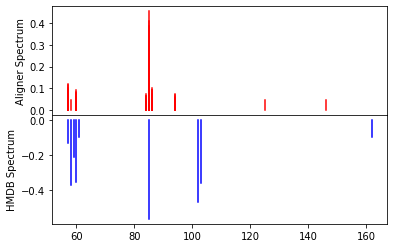

----
NaN  104.10696566944391
['l-leucine$l-isoleucine'] C00123;C00407
M+H[1+] : Dimethylglycine 103.1198 C4H9NO2 C01026 0.7251156318726362


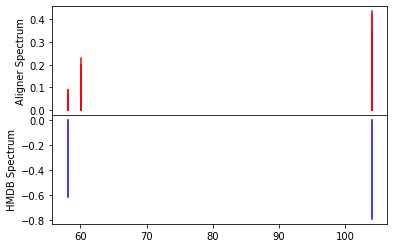

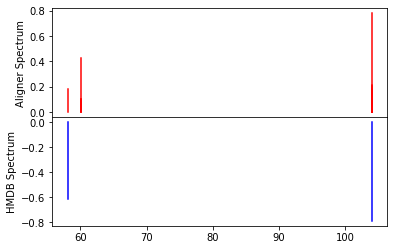

----
NaN  129.06585633127312
['l-glutamine$3-ureidoisobutyrate$d-glutamine; d-2-aminoglutaramic acid', '5,6-dihydrothymine', '4-guanidinobutanoate'] C01035
M(S34)+H[1+] : Thymine 126.1133 C5H6N2O2 C00178 0.07033713873412056


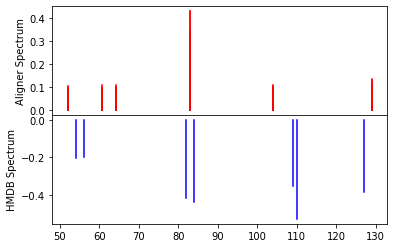

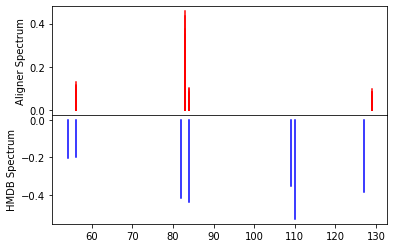

----
NaN  148.09679239908854
['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] C05936;C00408
----
NaN  193.0949299699169
NaN NaN
----
NaN  284.3309808949955
NaN NaN
----
pyridoxal C00250 168.06575625550514
['pyridoxal'] C00250
M+H[1+] : Quinolinic acid 167.1189 C7H5NO4 C03722 0.2553011125814786


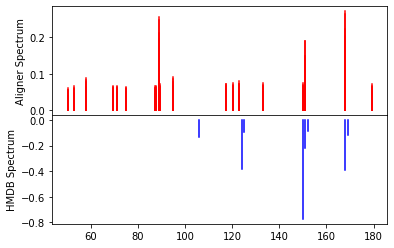

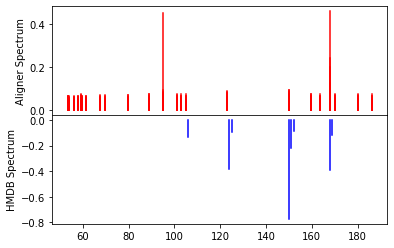

----
NaN  121.0688853012888
['l-allo-threonine$l-threonine'] C05519;C00188
----
NaN  129.10222498575843
['l-lysine', 'n2-acetyl-l-ornithine'] C00437
----
n(pi)-methyl-l-histidine  170.0924298604329
['n(pi)-methyl-l-histidine; 1-methylhistidine; n-pros-methyl-l-histidine'] C01152
M(S34)+H[1+] : Quinolinic acid 167.1189 C7H5NO4 C03722 0.16184993602536496


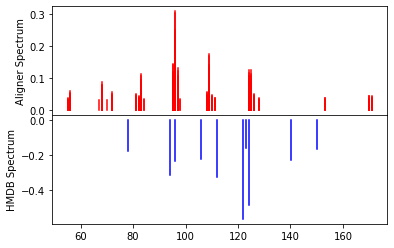

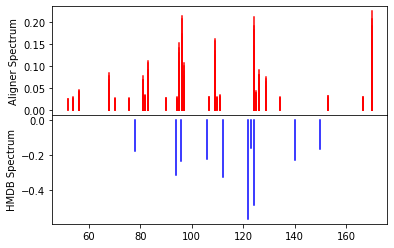

----
NaN  338.3416043599446
NaN NaN
M-CO+H[1+] : Amoxicillin 365.404 C16H19N3O5S C06827 0.20724797648794205


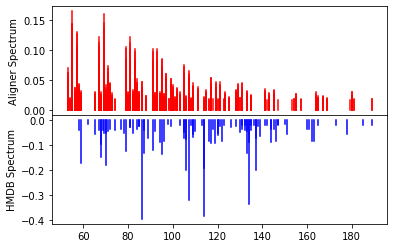

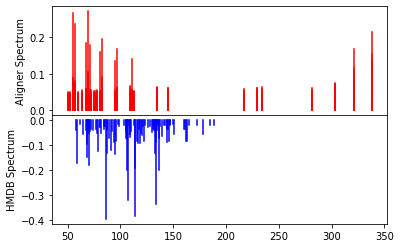

----
NaN  171.09577764223698
['n(pi)-methyl-l-histidine; 1-methylhistidine; n-pros-methyl-l-histidine'] C01152
----
NaN  790.622256192294
NaN NaN
----
NaN  149.10024290818438
NaN NaN
----
NaN  200.02707190262643
NaN NaN
M+HCOOK[1+] : L-Proline 115.1305 C5H9NO2 C00148 0.1098807983510672


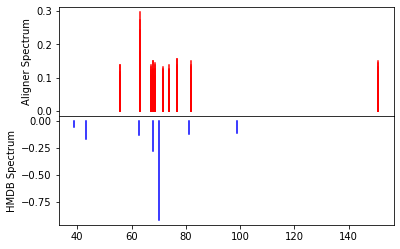

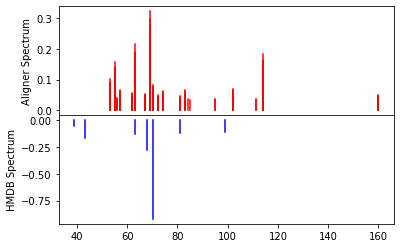

----
pantothenate  220.11800760904944
['(r)-pantothenate'] C00864
M+NaCl[1+] : L-Carnitine 161.1989 C7H15NO3 C00318 0.12648689915317113


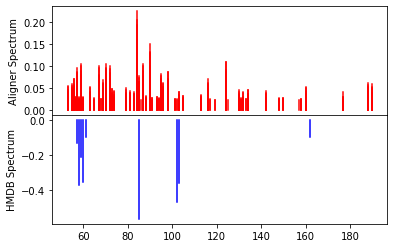

----
NaN  469.3888406062472
NaN NaN
M+H[1+] : Cromoglicic acid 468.3665 C23H16O11 C06928 0.07492059665503058


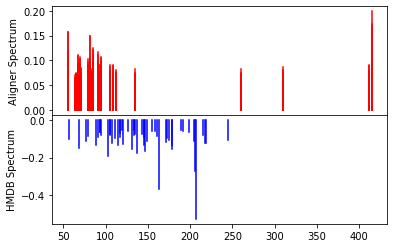

----
creatinine C00791 114.0550639629364
['porphobilinogen', 'l-glutamate 5-semialdehyde; l-glutamate gamma-semialdehyde$trans-4-hydroxy-l-proline$5-aminolevulinate; 5-amino-4-oxopentanoate; 5-amino-4-oxovaleric acid$cis-4-hydroxy-d-proline$5-amino-2-oxopentanoic acid; 5-amino-2-oxopentanoate; 2-oxo-5-amino-pentanoate; 2-oxo-5-aminopentanoate; alpha-keto-delta-aminopentanoate; 2-oxo-5-aminovalerate', '1-pyrroline-5-carboxylate$1-pyrroline-2-carboxylate; 1-pyrroline-2-carboxylic acid; delta1-pyrroline 2-carboxylate'] C03912;C03564
----
NaN  175.07143014936298
['n-formimidoyl-l-glutamate', '4-imidazolone-5-propanoate'] C03680
----
NaN  275.10333221435553
NaN NaN
----
NaN  164.0293822786701
NaN NaN
----
NaN  228.1225888801344
NaN NaN
----
NaN  160.03453098126312
NaN NaN
----
NaN  247.1440298750593
NaN NaN
M+K[1+] : L-Kynurenine 208.2139 C10H12N2O3 C00328 0.2951684353080986


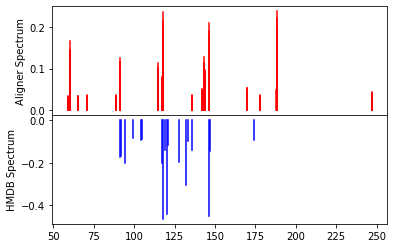

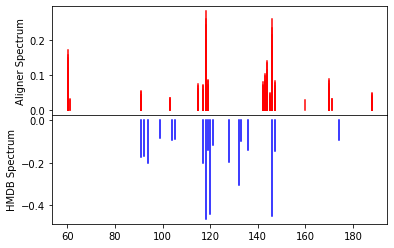

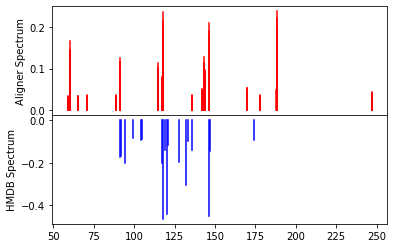

----
NaN  174.112584811538
['(r)-pantothenate'] C00864
----
NaN  86.09640022803997
['l-leucine$l-isoleucine', 'n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] C05936;C00408
M-H2O+H[1+] : Dimethylglycine 103.1198 C4H9NO2 C01026 0.24573382555875775


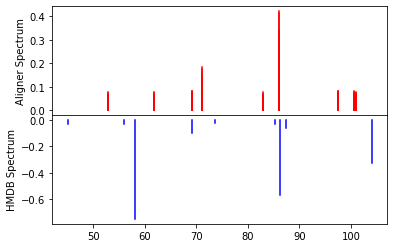

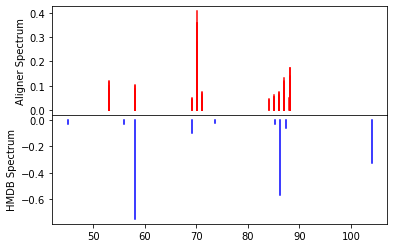

----
NaN  105.07399033663565
NaN NaN
----
NaN  171.07645396182414
NaN NaN
M+K[1+] : Ureidopropionic acid 132.1179 C4H8N2O3 C02642 0.111340919748946


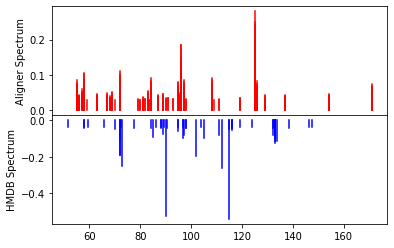

----
NaN  228.12311062059902
NaN NaN
----
NaN  119.08341081518877
NaN NaN
M(C13)+H[1+] : Betaine 117.1463 C5H11NO2 C00719 0.4691045488557135


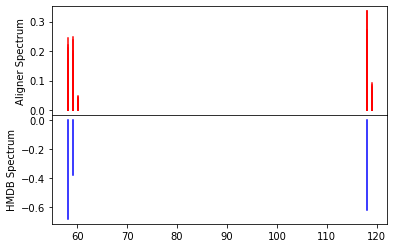

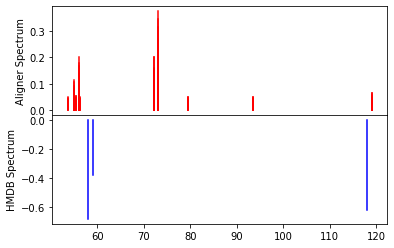

----
NaN  480.3447696940104
NaN NaN
----
l-homoserine C00263 120.0655581323724
['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', 'l-allo-threonine$l-threonine'] C05519;C00188
M+H[1+] : L-Threonine 119.1192 C4H9NO3 C00188 0.45599536394874823


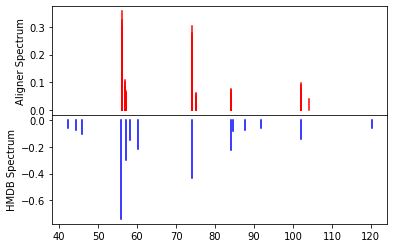

----
4-trimethylammoniobutanoate  146.11758242155375
['3-dehydroxycarnitine'] C05543
----
NaN  191.16419440821602
NaN NaN
----
l-carnitine C00318 162.1124855982114
['l-carnitine'] C00318
M+H[1+] : L-Carnitine 161.1989 C7H15NO3 C00318 0.4891108553190825


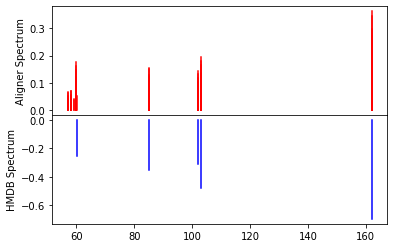

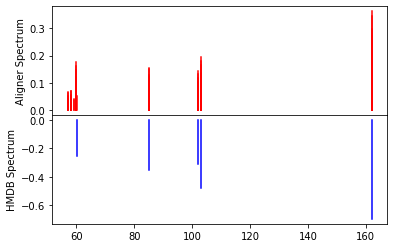

----
NaN  216.0584815054229
NaN NaN
----
maleic acid C00122 117.07394670185292
NaN NaN
----
NaN  284.19682928232044
NaN NaN
----
NaN  731.6055586751303
NaN NaN
----
l-phenylalanine C00079 166.08632090250651
['l-phenylalanine$', 'l-normetanephrine$l-adrenaline; (r)-(-)-adrenaline; (r)-(-)-epinephrine; (r)-(-)-epirenamine; (r)-(-)-adnephrine; 4-[(1r)-1-hydroxy-2-(methylamino)ethyl]-1,2-benzenediol'] C05589;C00788
M-H2O+H[1+] : 4-Pyridoxic acid 183.1614 C8H9NO4 C00847 0.1092115130945404


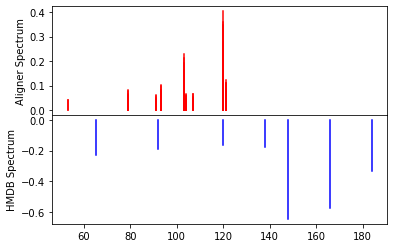

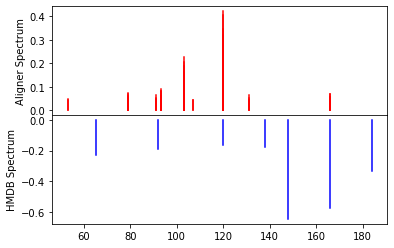

----
NaN  146.06005794901245
NaN NaN
----
NaN  188.0706503061148
['5-methoxyindoleacetate'] C05660
----
NaN  138.05495536327362
['anthranilate'] C00108
----
NaN  148.09681229842337
['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] C05936;C00408
M-H4O2+H[1+] : 4-Pyridoxic acid 183.1614 C8H9NO4 C00847 0.2380845291919352


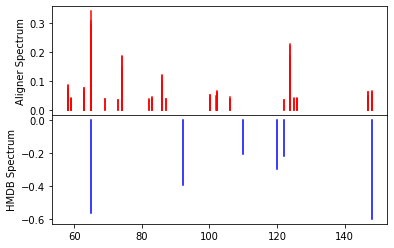

----
NaN  223.10774562233368
NaN NaN
----
NaN  130.06930080213044
['5,6-dihydrothymine'] C00906
----
NaN  789.6180069986979
NaN NaN
----
NaN  120.09293074356884
NaN NaN
----
NaN  74.06003565183828
['l-allo-threonine$l-threonine', 'aminoacetone$3-aminopropanal$beta-aminopropion aldehyde'] C01888;C02229;C05665
----
NaN  176.06584577418084
NaN NaN
----
NaN  70.06512395959152
['4-aminobutanal; 4-aminobutyraldehyde; butyraldehyde, 4-amino-', '1-pyrroline'] CE1944
M-HCOOH+H[1+] : L-Proline 115.1305 C5H9NO2 C00148 0.4179300561263688


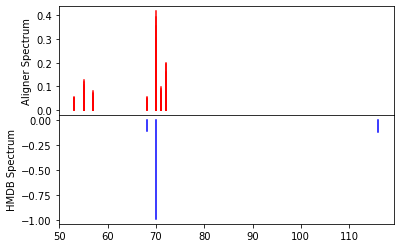

----
NaN  158.08124113736088
NaN NaN
----
betaine C00719 118.07718507867108
NaN NaN
M(S34)+H[1+] : L-Proline 115.1305 C5H9NO2 C00148 0.15237946275873385


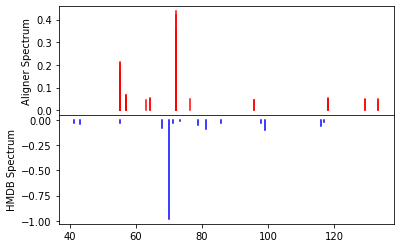

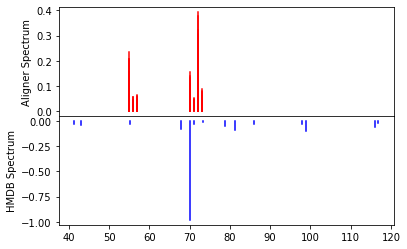

----
NaN  199.18053660074867
NaN NaN
M-HCOOK+H[1+] : Niflumic Acid 282.218 C13H9F3N2O2 C13698 0.20157624002959418


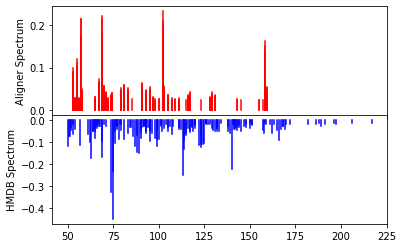

----
NaN  183.0781542125501
NaN NaN
----
NaN  119.08963886060215
['glycine betaine$5-aminopentanoate; 5-aminopentanoic acid; 5-aminovaleric acid$l-valine'] C00719;C00431;C00183
----
NaN  326.3780025135387
NaN NaN
M+H+Na[2+] : Lopinavir 628.8008 C37H48N4O5 C12871 0.07675688026698041


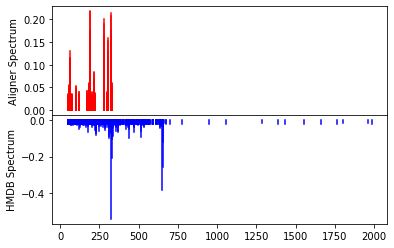

----
NaN  187.09644167188188
NaN NaN
----
creatinine C00791 114.06623158310398
['creatine; alpha-methylguanidino acetic acid; methylglycocyamine', 'nan'] C00791
M+H[1+] : Creatinine 113.1179 C4H7N3O C00791 0.5555199927568796


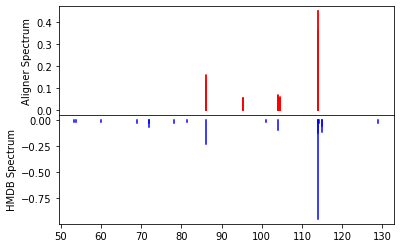

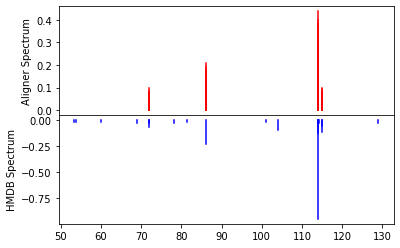

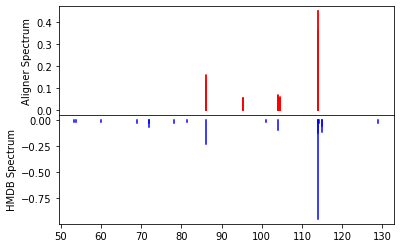

----
5-aminolevulinate  132.06559622915168
['l-glutamate 5-semialdehyde; l-glutamate gamma-semialdehyde$trans-4-hydroxy-l-proline$5-aminolevulinate; 5-amino-4-oxopentanoate; 5-amino-4-oxovaleric acid$cis-4-hydroxy-d-proline$5-amino-2-oxopentanoic acid; 5-amino-2-oxopentanoate; 2-oxo-5-amino-pentanoate; 2-oxo-5-aminopentanoate; alpha-keto-delta-aminopentanoate; 2-oxo-5-aminovalerate', '2-amino-4-oxopentanoic acid; 2-amino-4-oxopentanoate'] C03341
M+H[1+] : Creatine 131.1332 C4H9N3O2 C00300 0.3391426922938327


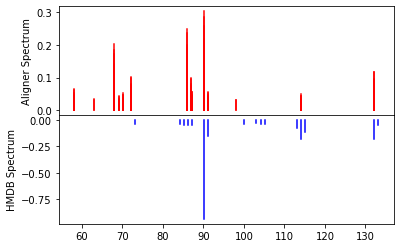

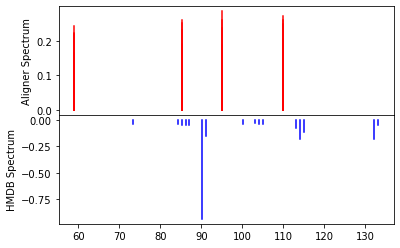

----
NaN  156.10199558734894
['l-normetanephrine$l-adrenaline; (r)-(-)-adrenaline; (r)-(-)-epinephrine; (r)-(-)-epirenamine; (r)-(-)-adnephrine; 4-[(1r)-1-hydroxy-2-(methylamino)ethyl]-1,2-benzenediol'] C05589;C00788
----
NaN  160.11619557832418
NaN NaN
----
betaine C00719 118.12018972124372
NaN NaN
----
NaN  198.0849804125334
['l-citrulline; 2-amino-5-ureidovaleric acid; citrulline'] C00327
M+Na[1+] : Indoleacetic acid 175.184 C10H9NO2 C00954 0.11148635615929758


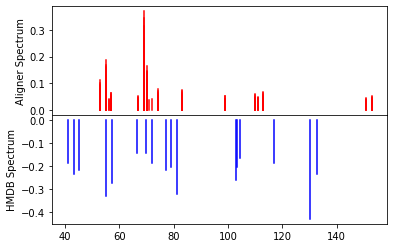

----
NaN  202.04272942793997
NaN NaN
----
NaN  240.1423659854465
NaN NaN
----
4-trimethylammoniobutanoate  146.08121083577473
['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproate$4-acetamidobutanoate$l-2-aminoadipate 6-semialdehyde; 2-aminoadipate 6-semialdehyde'] C03239;C02946;C04076
M+K[1+] : Benzylamine 107.1531 C7H9N C15562 0.18204721205408522


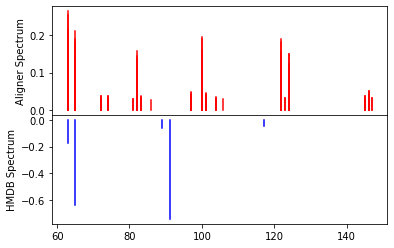

----
NaN  152.07063229878744
['6-acetamido-2-oxohexanoate; 2-oxo-6-acetamidocaproate', 'adrenochrome$hippurate; hippuric acid; n-benzoylglycine; benzoylaminoacetic acid', '3,4-dihydroxy-l-phenylalanine', 'norepinephrine$pyridoxine', 'leukoaminochrome'] CE5665
----
NaN  132.1019279078433
['5-acetamidopentanoate', 'l-leucine$l-isoleucine'] C00123;C00407
M+H[1+] : Creatine 131.1332 C4H9N3O2 C00300 0.24277785677384808


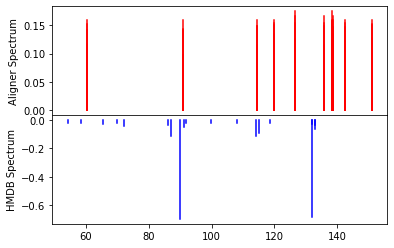

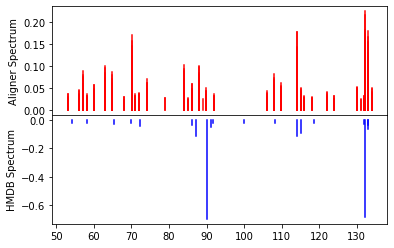

----
l-carnitine C00318 162.05017170761568
NaN NaN
M+NaCl[1+] : Dimethylglycine 103.1198 C4H9NO2 C01026 0.09212108779009245


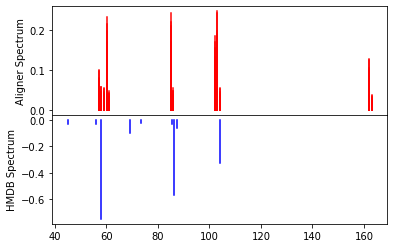

----
NaN  788.6709195650543
NaN NaN
----
NaN  228.1230882285297
NaN NaN
M-H4O2+H[1+] : Gemcitabine 263.1981 C9H11F2N3O4 C07650 0.15595690861376751


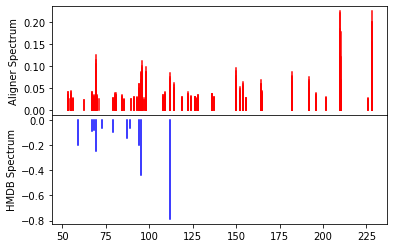

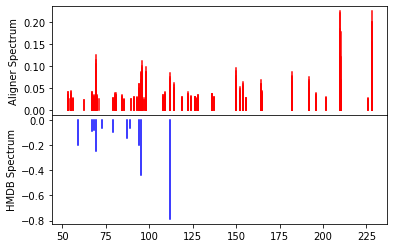

----
NaN  157.09724094993192
['n2-acetyl-l-ornithine'] C00437
M+H+Na[2+] : Argininosuccinic acid 290.2731 C10H18N4O6 C03406 0.29607833359624786


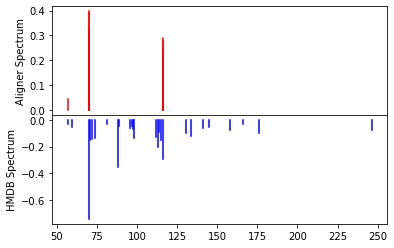

----
NaN  202.10732576923985
['l-normetanephrine$l-adrenaline; (r)-(-)-adrenaline; (r)-(-)-epinephrine; (r)-(-)-epirenamine; (r)-(-)-adnephrine; 4-[(1r)-1-hydroxy-2-(methylamino)ethyl]-1,2-benzenediol', '(r)-pantothenate'] C00864
----
NaN  115.0695485064858
['nan'] C00791
----
maleic acid C00122 117.06763443193935
NaN NaN
M(C13)+H[1+] : L-Proline 115.1305 C5H9NO2 C00148 0.4804180919590106


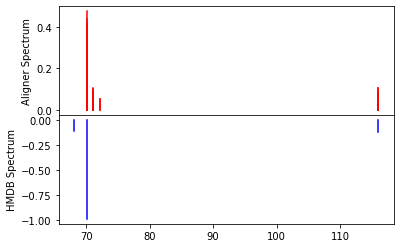

----
NaN  120.09051082008764
NaN NaN
----
pyridoxine C00314 170.1175746614971
['l-metanephrine'] C05588
----
NaN  174.11256066684066
NaN NaN
----
NaN  177.0546983083089
NaN NaN
----
NaN  202.1074665126516
['l-normetanephrine$l-adrenaline; (r)-(-)-adrenaline; (r)-(-)-epinephrine; (r)-(-)-epirenamine; (r)-(-)-adnephrine; 4-[(1r)-1-hydroxy-2-(methylamino)ethyl]-1,2-benzenediol', '(r)-pantothenate'] C00864
----
NaN  139.0179258777249
NaN NaN
M-H2O+H[1+] : Orotic acid 156.0963 C5H4N2O4 C00295 0.10349880444734312


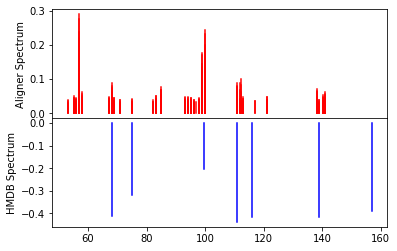

----
NaN  251.1852227487872
NaN NaN
----
NaN  201.11225086933857
['propionyl-carnitine'] pcrn
----
NaN  139.05013573169708
['4-imidazolone-5-propanoate', 'urocanate'] C00785
----
NaN  202.14386417554766
NaN NaN
----
NaN  300.20143837764346
NaN NaN
M+H2O+H[1+] : 1-Methyladenosine 281.2679 C11H15N5O4 C02494 0.029534100191891823


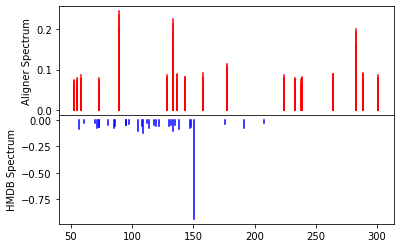

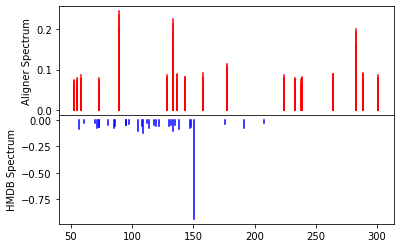

----
NaN  106.08629391644452
NaN NaN
----
NaN  158.11763867464933
NaN NaN
M-NH3+H[1+] : L-Arginine 174.201 C6H14N4O2 C00062 0.25613996616596296


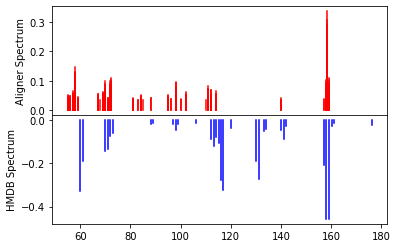

----
NaN  131.08965702380164
['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] C05936;C00408
M(C13)+H[1+] : Pipecolic acid 129.157 C6H11NO2 C00408 0.4288387599130686


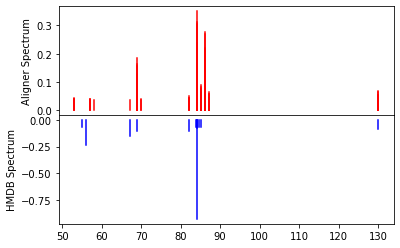

----
NaN  235.11863998628
NaN NaN
M-H4O2+H[1+] : Leflunomide 270.2073 C12H9F3N2O2 C07905 0.21644248482950174


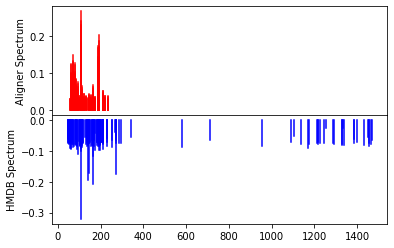

----
NaN  328.24814551217213
NaN NaN
----
NaN  734.5688444438733
NaN NaN
----
NaN  76.07570653279622
['l-allo-threonine$l-threonine'] C05519;C00188
M+H[1+] : Glycine 75.0666 C2H5NO2 C00037 0.23897673415289902


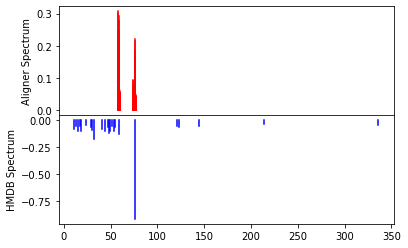

----
ala-gly  147.12094518300648
['3-dehydroxycarnitine'] C05543
M+H+Na[2+] : Apigenin 270.2369 C15H10O5 C01477 0.05316775787048946


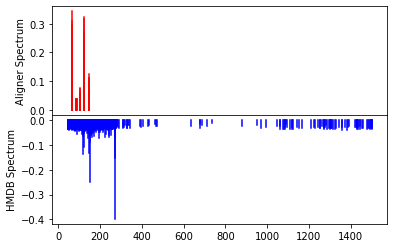

----
choline phosphate  183.9746935757724
NaN NaN
----
NaN  212.1493069192637
NaN NaN
----
NaN  139.05025895436606
['4-imidazolone-5-propanoate', 'urocanate'] C00785
M+H[1+] : Urocanic acid 138.124 C6H6N2O2 C00785 0.38892846154212596


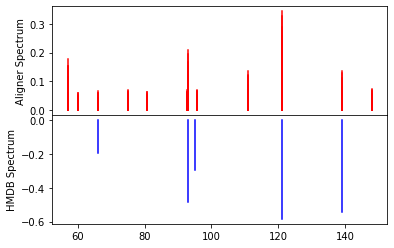

----
NaN  188.09180537989883
['6-acetamido-2-oxohexanoate; 2-oxo-6-acetamidocaproate'] C05548
----
NaN  196.1544508797781
NaN NaN
----
NaN  183.1016729254472
['ecgonine methyl ester; methyl ecgonine$ecgonine methyl ester'] C12448;egme
----
NaN  134.10612965901691
NaN NaN
----
NaN  119.08341056422184
NaN NaN
----
NaN  157.0738375938102
NaN NaN
----
NaN  526.3774294466584
NaN NaN
----
betaine C00719 118.05245122601907
NaN NaN
----
NaN  303.0239378276624
NaN NaN
----
NaN  454.29274400983536
NaN NaN
----
NaN  156.1020020031538
['l-normetanephrine$l-adrenaline; (r)-(-)-adrenaline; (r)-(-)-epinephrine; (r)-(-)-epirenamine; (r)-(-)-adnephrine; 4-[(1r)-1-hydroxy-2-(methylamino)ethyl]-1,2-benzenediol'] C05589;C00788
----
NaN  243.94808880488083
NaN NaN
----
NaN  102.06621345720795
NaN NaN
M+3H[3+] : Ethacrynic acid 303.138 C13H12Cl2O4 None 0.024219363771309864


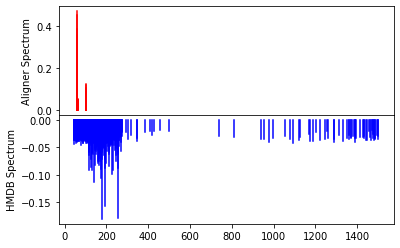

----
NaN  256.1654001871745
NaN NaN
M+H[1+] : Ganciclovir 255.2306 C9H13N5O4 None 0.1392288276333377


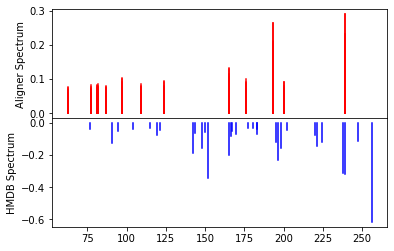

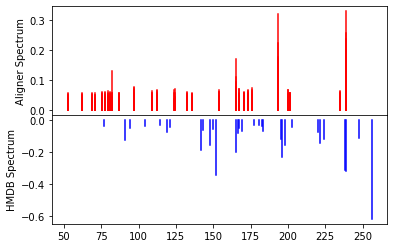

----
NaN  173.11715721717246
['nan', 'nan'] CE2577
M+NaCl[1+] : Dihydrouracil 114.1026 C4H6N2O2 C00429 0.17497856614338464


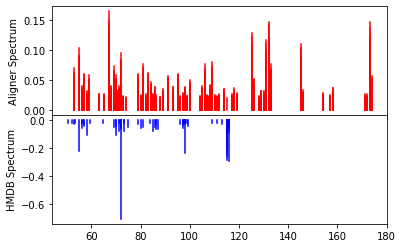

----
NaN  129.10223881648136
['l-lysine'] C00047
M-H2O+H[1+] : L-Lysine 146.1876 C6H14N2O2 C00047 0.20749517568585046


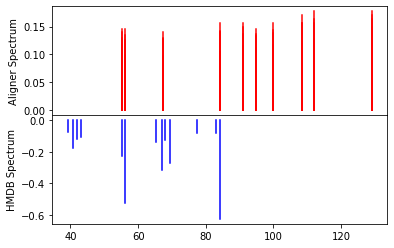

----
NaN  115.06321776540658
['acetamidopropanal$d-proline$l-proline'] CE4788;C00763;C00148
----
NaN  219.01899177149718
NaN NaN
----
NaN  139.058363369533
['anthranilate'] C00108
----
NaN  174.13186501167917
NaN NaN
M+HCOONa[1+] : L-Serine 105.0926 C3H7NO3 C00065 0.28777954676521794


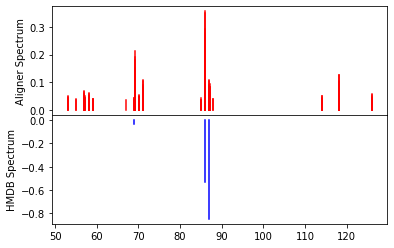

----
NaN  160.0968741833324
['5-acetamidopentanoate'] C03087
M-HCOOH+H[1+] : Xanthurenic acid 205.1669 C10H7NO4 C02470 0.08824028684743537


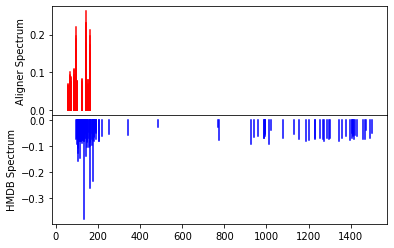

----
NaN  169.0859831689109
['n-trimethyl-2-aminoethylphosphonate; 2-trimethylaminoethylphosphonate'] C06459
----
5-aminolevulinate  132.07676277160644
['creatine; alpha-methylguanidino acetic acid; methylglycocyamine', 'nan'] C00791
M+H[1+] : Creatine 131.1332 C4H9N3O2 C00300 0.28953291527298636


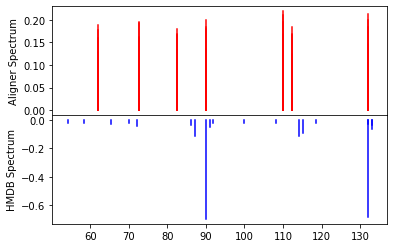

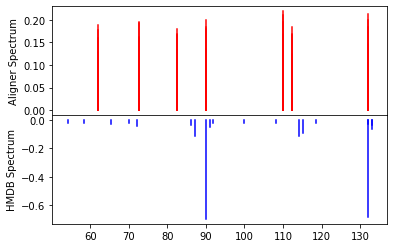

----
NaN  240.1422054893092
NaN NaN
----
NaN  787.6659161111583
NaN NaN
----
NaN  153.0910738099296
['nan'] C08261
----
NaN  155.09272153753983
NaN NaN
----
NaN  216.1595422845137
NaN NaN
M+H2O+H[1+] : L-Dopa 197.1879 C9H11NO4 C00355 0.32499289309599527


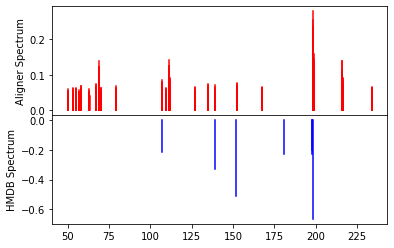

----
NaN  612.5196630859375
NaN NaN
M+HCOONa[1+] : Epirubicin 543.5193 C27H29NO11 C11230 0.03872543500664475


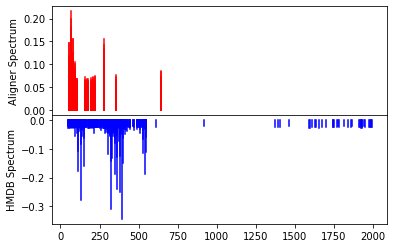

----
NaN  119.08964096872428
['glycine betaine$5-aminopentanoate; 5-aminopentanoic acid; 5-aminovaleric acid$l-valine'] C00719;C00431;C00183
----
NaN  120.09291960063732
NaN NaN
----
NaN  218.13873609855995
['propionyl-carnitine', 'ecgonine methyl ester; methyl ecgonine$ecgonine methyl ester'] C12448;egme
----
NaN  266.121456269295
['alpha-n-phenylacetyl-l-glutamine$formyl-n-acetyl-5-methoxykynurenamine'] C04148;C05642
----
4-(beta-acetylaminoethyl)imidazole  154.04986931937088
['3-hydroxyanthranilate'] C00632
----
NaN  157.0860331608699
NaN NaN
----
NaN  185.1285421708051
NaN NaN
M(C13)+H[1+] : 4-Pyridoxic acid 183.1614 C8H9NO4 C00847 0.1251520680957472


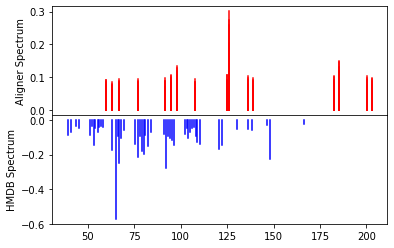

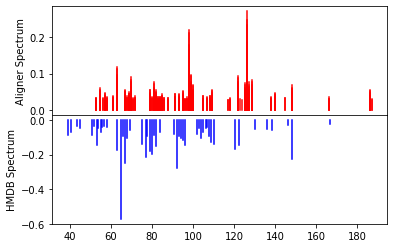

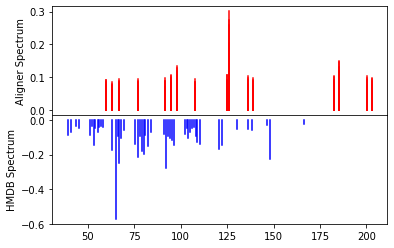

----
NaN  72.08080402173493
['glycine betaine$5-aminopentanoate; 5-aminopentanoic acid; 5-aminovaleric acid$l-valine'] C00719;C00431;C00183
M-H2O+H[1+] : beta-Alanine 89.0932 C3H7NO2 C00099 0.1052190525848257


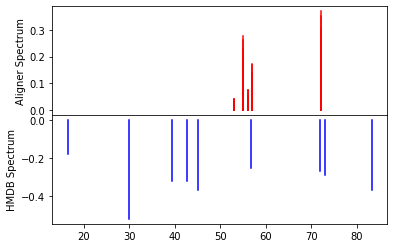

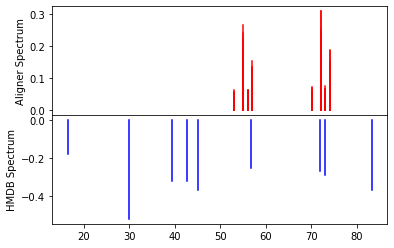

----
NaN  134.10863405863444
NaN NaN
----
NaN  230.1580113429649
NaN NaN
----
NaN  116.07047700881958
['acetamidopropanal$d-proline$l-proline'] CE4788;C00763;C00148
----
imidazole-4-acetate  127.05023574829102
['thymine$imidazole-4-acetate; imidazoleacetic acid; 4-imidazoleacetate'] C00178;C02835
----
NaN  142.08635962009433
['5-acetamidopentanoate'] C03087
M+Na[1+] : L-Threonine 119.1192 C4H9NO3 C00188 0.12877211586169052


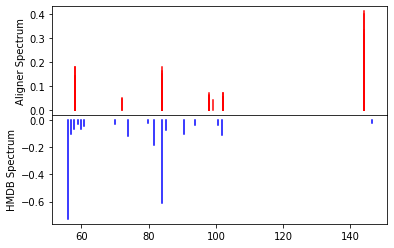

----
NaN  156.13839948177338
NaN NaN
----
NaN  188.09179316068955
['6-acetamido-2-oxohexanoate; 2-oxo-6-acetamidocaproate', 'norepinephrine$pyridoxine'] C00547;C00314
----
NaN  198.11259257793427
['l-metanephrine'] C05588
----
NaN  103.06953181642471
NaN NaN
----
NaN  148.06044561212713
['d-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', 'dl-glutamate; dl-glutaminic acid; 2-aminoglutaric acid; glutamate'] C00302
----
NaN  236.11285226004463
NaN NaN
----
NaN  102.05497400084538
['5-oxoproline$l-1-pyrroline-3-hydroxy-5-carboxylate$1-pyrroline-4-hydroxy-2-carboxylate', 'd-glutamate; d-glutamic acid; d-glutaminic acid; d-2-aminoglutaric acid$l-glutamate$l-4-hydroxyglutamate semialdehyde', 'l-allo-threonine$l-threonine'] C05519;C00188
----
NaN  246.24264697024697
NaN NaN
----
hypoxanthine C00262 137.04583913167318
['hypoxanthine'] C00262
M+H[1+] : Hypoxanthine 136.1115 C5H4N4O C00262 0.48549072398829063


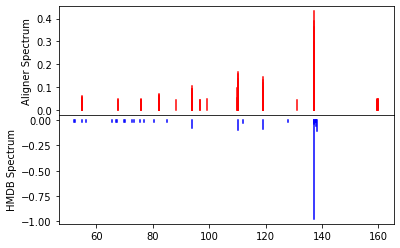

----
NaN  508.37631204094686
['lysophosphatidylcholine'] C04230
----
NaN  118.06108459673428
['guanidinoacetate; guanidinoacetic acid; glycocyamine; n-amidinoglycine; guanidoacetic acid$guanidinoacetate'] C00581;gudac
M+H[1+] : Betaine 117.1463 C5H11NO2 C00719 0.1878174370767879


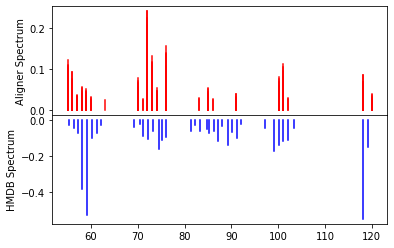

----
NaN  496.3396652430704
['docosa-4,7,10,13,16-pentaenoyl carnitine$clupanodonyl carnitine'] dcsptn1crn;clpndcrn
----
imidazole-4-acetate  127.07272237889907
NaN NaN
----
NaN  181.03970273335773
NaN NaN
----
NaN  144.10197530110676
NaN NaN
M-HCOOH+H[1+] : Kynurenic acid 189.1675 C10H7NO3 C01717 0.49705084494029333


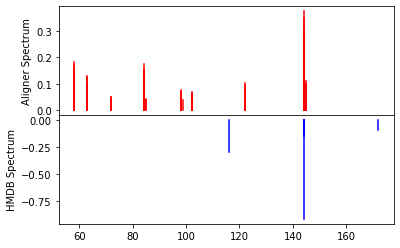

----
NaN  343.1896204168146
["cortisone; 17alpha,21-dihydroxy-4-pregnene-3,11,20-trione; kendall's compound e; reichstein's substance fa$aldosterone; 11beta,21-dihydroxy-3,20-dioxo-4-pregnen-18-al"] C00762;C01780
----
NaN  682.4863531324597
NaN NaN
----
NaN  144.10198930381
['6-acetamido-2-oxohexanoate; 2-oxo-6-acetamidocaproate'] C05548
----
NaN  130.08630989693307
['n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] C05936;C00408
----
NaN  217.17992833455403
NaN NaN
----
NaN  145.09719601192992
NaN NaN
----
betaine C00719 118.0862263629311
['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproate$4-acetamidobutanoate$l-2-aminoadipate 6-semialdehyde; 2-aminoadipate 6-semialdehyde', 'glycine betaine$5-aminopentanoate; 5-aminopentanoic acid; 5-aminovaleric acid$l-valine'] C00719;C00431;C00183
----
NaN  120.0905162911666
NaN NaN
----
NaN  239.13897132873527
NaN NaN
M-CO2+H[1+] : Niflumic Acid 282.218 C13H9F3N2O2 C13698 0.25943167070583967


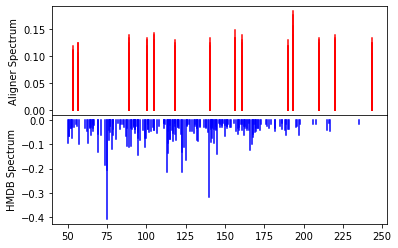

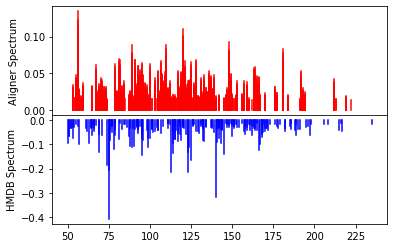

----
NaN  151.09652974870468
NaN NaN
----
NaN  200.1282397508621
['propionyl-carnitine', 'ecgonine methyl ester; methyl ecgonine$ecgonine methyl ester'] C12448;egme
----
l-leucine C00123 132.14208027232777
NaN NaN
----
NaN  148.0967851587244
['(r)-pantothenate', 'n4-acetylaminobutanal$l-pipecolate; pipecolinic acid; pipecolic acid; 2-piperidinecarboxylic acid'] C05936;C00408
M-H4O2+H[1+] : 4-Pyridoxic acid 183.1614 C8H9NO4 C00847 0.2308221620676222


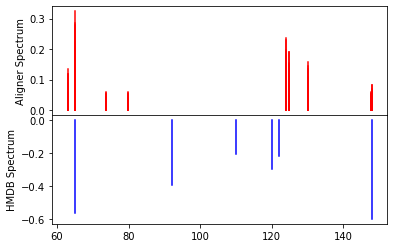

----
NaN  681.4831514485677
NaN NaN
----
NaN  159.11286996540267
NaN NaN
M-NH3+H[1+] : Indoleacetic acid 175.184 C10H9NO2 C00954 0.17020043888508127


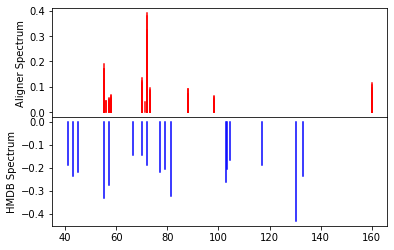

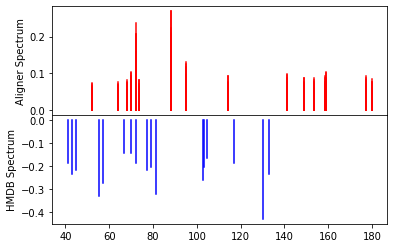

----
NaN  142.94811766488212
NaN NaN
M+K[1+] : Malonic acid 104.0615 C3H4O4 C04025 0.0434846506244652


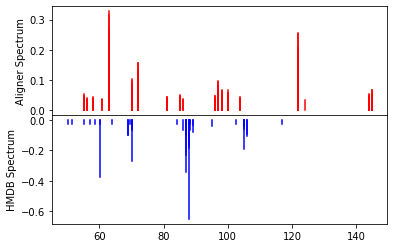

----
NaN  257.11304651547783
NaN NaN
----
betaine C00719 118.08624432538006
['6-amino-2-oxohexanoate; 2-oxo-6-aminocaproate$4-acetamidobutanoate$l-2-aminoadipate 6-semialdehyde; 2-aminoadipate 6-semialdehyde', 'glycine betaine$5-aminopentanoate; 5-aminopentanoic acid; 5-aminovaleric acid$l-valine', 'l-2-aminoadipate; l-alpha-aminoadipate; l-alpha-aminoadipic acid; l-2-aminoadipic acid; l-2-aminohexanedioate'] C00956
M+H[1+] : Betaine 117.1463 C5H11NO2 C00719 0.6635662941527527


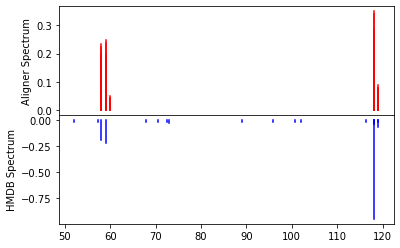

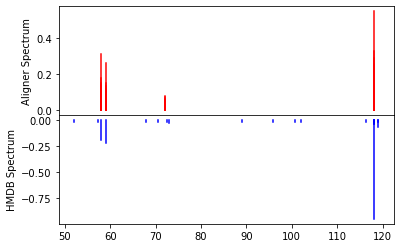

----
NaN  264.1804777292105
NaN NaN
----
NaN  186.1125436731287
NaN NaN
M(S34)+H[1+] : 4-Pyridoxic acid 183.1614 C8H9NO4 C00847 0.08767314675757812


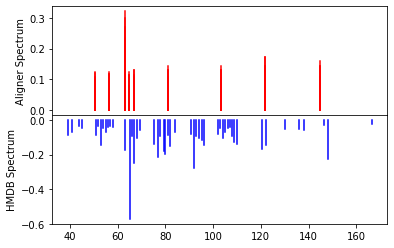

----
creatinine C00791 114.03404131802642
NaN NaN
M+H[1+] : Creatinine 113.1179 C4H7N3O C00791 0.5602085409996662


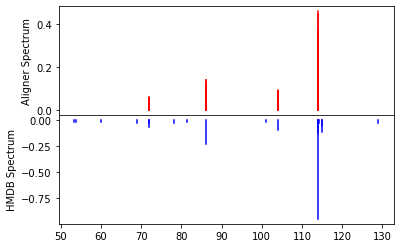

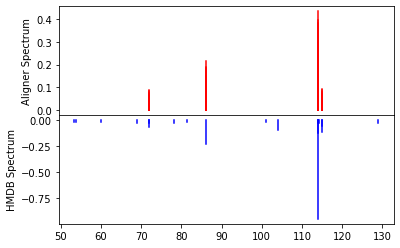

----


In [53]:
%matplotlib inline
for peak in peakInfoList:
    
    print(peak.std_annotation, peak.std_kegg_id, peak.mz)
    print(peak.mm_annotation, peak.mm_kegg_id)
    normalised_peaks_top_list = []
    normalised_peaks_bottom_list = []
    
    if peak.best_ms2_match_adduct: 
        print(peak.best_ms2_match_adduct.name, ":",
              metabolites[peak.best_ms2_match_adduct.hmdb][2],
              metabolites[peak.best_ms2_match_adduct.hmdb][0],
              metabolites[peak.best_ms2_match_adduct.hmdb][1],
              metabolites[peak.best_ms2_match_adduct.hmdb][5], peak.best_ms2_match_adduct.score)
        if peak.best_ms2_match_adduct.ms2spec:
                normalised_peaks_bottom = peak.best_ms2_match_adduct.ms2spec.normalised_peaks
                normalised_peaks_bottom_list.append(normalised_peaks_bottom)

        
    if peak.spectra:

        spectra = peak.spectra
            
        for spectrum in spectra:
                
            normalised_peaks_top = spectra[spectrum].normalised_peaks
            normalised_peaks_top_list.append(normalised_peaks_top)



    for top in normalised_peaks_top_list:
        for bottom in normalised_peaks_bottom_list:
            plot_mirror(top, bottom)

        
        
    print('----')

In [52]:
from rdkit import Chem,DataStructs
mol1 = Chem.MolFromSmiles("CC(C)C=CCCCCC(=O)NCc1ccc(c(c1)OC)O")
mol2 = Chem.MolFromSmiles("COC1=C(C=CC(=C1)C=O)O")
fp1 = Chem.RDKFingerprint(mol1)
fp2 = Chem.RDKFingerprint(mol2)
print("RDK fingerprint: ",DataStructs.TanimotoSimilarity(fp1,fp2))


ModuleNotFoundError: No module named 'rdkit'